# Benchmark transcriptome representations on Tahoe for prediction of clinical success 

In [1]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
from datasets import load_dataset

from classifier import *

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load clinical approval annotation

In [3]:
# Load drug metadata from huggingface
ds = load_dataset("tahoebio/Tahoe-100M", "drug_metadata")
drug_metadata = ds["train"].to_pandas()
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid'].astype(str)
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid_str'].str.split('\\.0').str[0]

cs = load_dataset("tahoebio/Tahoe-100M", "cell_line_metadata")
cell_line_metadata = cs["train"].to_pandas()
cell_line_metadata.head()

# Create a mapping from cell line ID to organ
cell_line_to_organ = dict(zip(cell_line_metadata['Cell_ID_Cellosaur'], cell_line_metadata['Organ']))

# Create a list of all drug names vs all cell line names (Cell_ID_Cellosaur)
# First, get unique drug names and cell line IDs
unique_drugs = drug_metadata['drug'].unique()
unique_cell_lines = cell_line_metadata['Cell_ID_Cellosaur'].unique()

# Create a DataFrame with all combinations of drugs and cell lines
drug_cellline_combinations = []
for drug in unique_drugs:
    for cell_line in unique_cell_lines:
        drug_cellline_combinations.append({
            'drug': drug,
            'cell_line': cell_line,
            'drug-cell_line': f"{drug}_{cell_line}"
        })

# Convert to DataFrame
drug_cellline_df = pd.DataFrame(drug_cellline_combinations)

# Display the first few rows
print(f"Total combinations: {len(drug_cellline_df)}")
drug_cellline_df.head()
# Add organ information to the drug_cellline_df
drug_cellline_df['organ'] = drug_cellline_df['cell_line'].map(cell_line_to_organ)

# Create a drug_organ column by combining drug name and organ
drug_cellline_df['drug_organ'] = drug_cellline_df['drug'] + '_' + drug_cellline_df['organ']

drug_cellline_df


Total combinations: 38658


drug  cell_line        drug-cell_line         organ  \
0            Talc  CVCL_0023        Talc_CVCL_0023          Lung   
1            Talc  CVCL_1286        Talc_CVCL_1286          Lung   
2            Talc  CVCL_1282        Talc_CVCL_1282  Vulva/Vagina   
3            Talc  CVCL_1034        Talc_CVCL_1034          Skin   
4            Talc  CVCL_2610        Talc_CVCL_2610          Skin   
...           ...        ...                   ...           ...   
38653  γ-Oryzanol  CVCL_1547  γ-Oryzanol_CVCL_1547          Lung   
38654  γ-Oryzanol  CVCL_1495  γ-Oryzanol_CVCL_1495          Lung   
38655  γ-Oryzanol  CVCL_1531  γ-Oryzanol_CVCL_1531          Lung   
38656  γ-Oryzanol  CVCL_1517  γ-Oryzanol_CVCL_1517          Lung   
38657  γ-Oryzanol  CVCL_1381  γ-Oryzanol_CVCL_1381          Skin   

              drug_organ  
0              Talc_Lung  
1              Talc_Lung  
2      Talc_Vulva/Vagina  
3              Talc_Skin  
4              Talc_Skin  
...                  ...  
38653    γ-Oryzanol_Lung  
38654    γ-Oryzanol_Lung  
38655    γ-Oryzanol_Lung  
38656    γ-Oryzanol_Lung  
38657    γ-Oryzanol_Skin  

[38658 rows x 5 columns]

In [4]:
# Read approval tables
approved_df = pd.read_csv('data/drugs_organs_approved.csv', index_col=0)
tested_df = pd.read_csv('data/drugs_organs_tested.csv', index_col=0)

# Map from pubchem_id to drug name
pubchem_to_drug = dict(zip(drug_metadata['pubchem_cid_str'].astype(str), drug_metadata['drug']))
tested_df.index = tested_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))
approved_df.index = approved_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))

# Melt the dataframes to have drug column and organ column
long_approved_df = approved_df.melt(var_name='organ', value_name='is_approved', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_approved_df['drug_organ'] = long_approved_df['drug'] + '_' + long_approved_df['organ']

long_tested_df = tested_df.melt(var_name='organ', value_name='is_tested', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_tested_df['drug_organ'] = long_tested_df['drug'] + '_' + long_tested_df['organ']

# Filter to only tested combos
long_approved_df = long_approved_df[long_tested_df['is_tested'] == 1]

## Load transcriptome representations from Tahoe

In [5]:
# E-distance
edist = pd.read_csv('./data_for_classifier/tahoe_largest_edist_per_drug_cell_line_combo.csv')
edist['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[edist['cell_line']].Cell_ID_Cellosaur.values
edist['drug-cell_line'] = edist['drug_name'].astype(str) + '_' + edist['cell_line'].astype(str)
edist_df = edist.set_index('drug-cell_line')[['max_e_distance']]
edist_df = edist_df[edist_df.index.isin(drug_cellline_df['drug-cell_line'])]
edist_df['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[edist_df.index]['drug_organ']

edist_df.to_csv('./data_for_classifier/max_edist.csv')
edist_df.head()

max_e_distance               drug_organ
drug-cell_line                                                      
Homoharringtonine_CVCL_1097       77.017775   Homoharringtonine_Skin
Homoharringtonine_CVCL_0218       77.017775  Homoharringtonine_Bowel
Harringtonine_CVCL_1478           70.707085       Harringtonine_Lung
Homoharringtonine_CVCL_0366       77.017775  Homoharringtonine_Liver
Homoharringtonine_CVCL_1285       77.017775   Homoharringtonine_Lung

In [6]:
# LDVAE
ldvae_raw_emb = pd.read_table('./data_for_classifier/ldvae_raw_embeddings.tsv', index_col=0)
ldvae_raw_emb.head()
ldvae_raw_emb['drug_name'] = ldvae_raw_emb.index.str.split('_').str[0]
ldvae_raw_emb['cell_line'] = ldvae_raw_emb.index.str.split('_').str[1:].str.join('_')
ldvae_raw_emb['drug-cell_line'] = ldvae_raw_emb['drug_name'].astype(str) + '_' + ldvae_raw_emb['cell_line'].astype(str)
ldvae_raw_emb.index = ldvae_raw_emb['drug-cell_line']
ldvae_raw_emb = ldvae_raw_emb[ldvae_raw_emb.index.isin(drug_cellline_df['drug-cell_line'])]
ldvae_raw_emb = ldvae_raw_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
ldvae_raw_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[ldvae_raw_emb.index]['drug_organ']
ldvae_raw_emb.head()

ldvae_0   ldvae_1   ldvae_2  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.014600  0.012926  0.011710   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.014513  0.013118  0.011858   
(S)-Crizotinib_CVCL_0023                 0.016476  0.012883  0.011638   
(S)-Crizotinib_CVCL_0023                 0.018304  0.013649  0.012170   
18β-Glycyrrhetinic acid_CVCL_0023        0.014723  0.013006  0.011624   

                                          ldvae_3   ldvae_4   ldvae_5  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.012142  0.015835  0.012668   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.012563  0.015460  0.013849   
(S)-Crizotinib_CVCL_0023                 0.011366  0.013653  0.012771   
(S)-Crizotinib_CVCL_0023                 0.011906  0.014439  0.012723   
18β-Glycyrrhetinic acid_CVCL_0023        0.012465  0.015860  0.013959   

                                          ldvae_6   ldvae_7   ldvae_8  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.321517  0.013512  0.013467   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.277566  0.013805  0.014732   
(S)-Crizotinib_CVCL_0023                 0.268295  0.014960  0.014189   
(S)-Crizotinib_CVCL_0023                 0.278399  0.015728  0.012894   
18β-Glycyrrhetinic acid_CVCL_0023        0.286499  0.013663  0.015108   

                                          ldvae_9  ...  ldvae_41  ldvae_42  \
drug-cell_line                                     ...                       
(R)-Verapamil (hydrochloride)_CVCL_0023  0.015075  ...  0.012238  0.016818   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.015866  ...  0.013585  0.018127   
(S)-Crizotinib_CVCL_0023                 0.015441  ...  0.014006  0.016438   
(S)-Crizotinib_CVCL_0023                 0.015095  ...  0.013581  0.016491   
18β-Glycyrrhetinic acid_CVCL_0023        0.015379  ...  0.013118  0.018286   

                                         ldvae_43  ldvae_44  ldvae_45  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.013118  0.014569  0.007875   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.012955  0.014728  0.009153   
(S)-Crizotinib_CVCL_0023                 0.012684  0.014392  0.009420   
(S)-Crizotinib_CVCL_0023                 0.013863  0.014496  0.009939   
18β-Glycyrrhetinic acid_CVCL_0023        0.012416  0.014518  0.008583   

                                         ldvae_46  ldvae_47  ldvae_48  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.011687  0.013895  0.014879   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.013128  0.015036  0.016103   
(S)-Crizotinib_CVCL_0023                 0.013180  0.014221  0.018036   
(S)-Crizotinib_CVCL_0023                 0.013252  0.013527  0.016531   
18β-Glycyrrhetinic acid_CVCL_0023        0.012813  0.014735  0.015741   

                                         ldvae_49  \
drug-cell_line                                      
(R)-Verapamil (hydrochloride)_CVCL_0023  0.013313   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.014588   
(S)-Crizotinib_CVCL_0023                 0.015372   
(S)-Crizotinib_CVCL_0023                 0.015062   
18β-Glycyrrhetinic acid_CVCL_0023        0.014192   

                                                                 drug_organ  
drug-cell_line                                                               
(R)-Verapamil (hydrochloride)_CVCL_0023  (R)-Verapamil (hydrochloride)_Lung  
(R)-Verapamil (hydrochloride)_CVCL_0023  (R)-Verapamil (hydrochloride)_Lung  
(S)-Crizotinib_CVCL_0023                                (S)-Crizotinib_Lung  
(S)-Crizotinib_CVCL_0023                                (S)-Crizotinib_Lung  
18β-Glycyrrhetinic acid_CVCL_0023              18β-Glycyrrhetinic acid_Lung  

[5 rows x 51 col

In [7]:
# LDVAE (vs ctrls)
ldvae_emb = pd.read_table('./data_for_classifier/ldvae_embeddings.tsv', index_col=0)
ldvae_emb.head()
ldvae_emb['drug_name'] = ldvae_emb.index.str.split('_').str[0]
ldvae_emb['cell_line'] = ldvae_emb.index.str.split('_').str[1:].str.join('_')
ldvae_emb['drug-cell_line'] = ldvae_emb['drug_name'].astype(str) + '_' + ldvae_emb['cell_line'].astype(str)
ldvae_emb.index = ldvae_emb['drug-cell_line']
ldvae_emb = ldvae_emb[ldvae_emb.index.isin(drug_cellline_df['drug-cell_line'])]
ldvae_emb = ldvae_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
ldvae_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[ldvae_emb.index]['drug_organ']
ldvae_emb.head()

ldvae_minusctrl_0  ldvae_minusctrl_1  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.001000          -0.000458   
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.001088          -0.000266   
(S)-Crizotinib_CVCL_0023                          0.000876          -0.000501   
(S)-Crizotinib_CVCL_0023                          0.002703           0.000265   
18β-Glycyrrhetinic acid_CVCL_0023                -0.000877          -0.000378   

                                         ldvae_minusctrl_2  ldvae_minusctrl_3  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000062           0.000143   
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000210           0.000563   
(S)-Crizotinib_CVCL_0023                         -0.000010          -0.000634   
(S)-Crizotinib_CVCL_0023                          0.000522          -0.000093   
18β-Glycyrrhetinic acid_CVCL_0023                -0.000024           0.000465   

                                         ldvae_minusctrl_4  ldvae_minusctrl_5  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000520           0.000020   
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000144           0.001201   
(S)-Crizotinib_CVCL_0023                         -0.001663           0.000123   
(S)-Crizotinib_CVCL_0023                         -0.000876           0.000075   
18β-Glycyrrhetinic acid_CVCL_0023                 0.000544           0.001311   

                                         ldvae_minusctrl_6  ldvae_minusctrl_7  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023           0.024449          -0.001167   
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.019502          -0.000874   
(S)-Crizotinib_CVCL_0023                         -0.028773           0.000282   
(S)-Crizotinib_CVCL_0023                         -0.018669           0.001050   
18β-Glycyrrhetinic acid_CVCL_0023                -0.010569          -0.001016   

                                         ldvae_minusctrl_8  ldvae_minusctrl_9  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.000530          -0.000126   
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000735           0.000665   
(S)-Crizotinib_CVCL_0023                          0.000192           0.000240   
(S)-Crizotinib_CVCL_0023                         -0.001103          -0.000106   
18β-Glycyrrhetinic acid_CVCL_0023                 0.001111           0.000178   

                                         ...  ldvae_minusctrl_41  \
drug-cell_line                           ...                       
(R)-Verapamil (hydrochloride)_CVCL_0023  ...           -0.000989   
(R)-Verapamil (hydrochloride)_CVCL_0023  ...            0.000357   
(S)-Crizotinib_CVCL_0023                 ...            0.000779   
(S)-Crizotinib_CVCL_0023                 ...            0.000353   
18β-Glycyrrhetinic acid_CVCL_0023        ...           -0.000109   

                                         ldvae_minusctrl_42  \
drug-cell_line                                                
(R)-Verapamil (hydrochloride)_CVCL_0023            0.000180   
(R)-Verapamil (hydrochloride)_CVCL_0023            0.001489   
(S)-Crizotinib_CVCL_0023                          -0.000200   
(S)-Crizotinib_CVCL_0023                          -0.000147   
18β-Glycyrrhetinic acid_CVCL_0023                  0.001648   

                                         ldvae_minusctrl_43  \
drug-cell_line                                                
(R)-Verapamil (hydrochloride)_CVCL_0023            0.000247   
(R)-Verapamil (hydrochloride)_CVCL_0023            0.000085   
(S)-Crizotinib_CVCL_0023      

In [ ]:
# mrVI (vs ctrls)
mrvi_emb = pd.read_csv('./data_for_classifier/tahoe_pseudobulk_z-space_by_sample.csv', index_col=0)
mrvi_emb['cell_line'] = mrvi_emb.index.str.split('_').str[0]
mrvi_emb['drug_name'] = mrvi_emb.index.str.split('_').str[1]

# Filter DMSO controls
ctrl_emb = mrvi_emb[mrvi_emb.index.str.contains('DMSO')]

# Create a dictionary mapping cell lines to their DMSO control embeddings
cell_to_ctrl = {}
for idx, row in ctrl_emb.iterrows():
    cell_line = row['cell_line']
    # Store the embedding values (excluding metadata columns)
    cell_to_ctrl[cell_line] = row.drop(['cell_line', 'drug_name']).values

# Create a new dataframe with the same columns as the original (excluding metadata)
feature_cols = [col for col in mrvi_emb.columns if col not in ['cell_line', 'drug_name']]
mrvi_minusctrl_emb = pd.DataFrame(index=mrvi_emb.index, columns=feature_cols)

# Subtract DMSO control effect for each cell line
for idx, row in mrvi_emb.iterrows():
    cell_line = row['cell_line']
    if cell_line in cell_to_ctrl and not idx.endswith('DMSO'):
        # Get the feature values (excluding metadata)
        treatment_values = row[feature_cols].values
        # Subtract control embedding from treatment embedding
        diff_values = treatment_values - cell_to_ctrl[cell_line]
        # Assign the difference to the new dataframe
        mrvi_minusctrl_emb.loc[idx, :] = diff_values

# Add back metadata columns
mrvi_minusctrl_emb['cell_line'] = mrvi_emb['cell_line']
mrvi_minusctrl_emb['drug_name'] = mrvi_emb['drug_name']

# Map cell line names to Cell_ID_Cellosaur
mrvi_minusctrl_emb['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[mrvi_minusctrl_emb['cell_line']].Cell_ID_Cellosaur.values
mrvi_minusctrl_emb['drug-cell_line'] = mrvi_minusctrl_emb['drug_name'].astype(str) + '_' + mrvi_minusctrl_emb['cell_line'].astype(str)
mrvi_minusctrl_emb.index = mrvi_minusctrl_emb['drug-cell_line']
mrvi_minusctrl_emb = mrvi_minusctrl_emb[mrvi_minusctrl_emb.index.isin(drug_cellline_df['drug-cell_line'])]
mrvi_minusctrl_emb = mrvi_minusctrl_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
mrvi_minusctrl_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[mrvi_minusctrl_emb.index]['drug_organ']
mrvi_minusctrl_emb.head()

In [180]:
# mrVI
mrvi_emb = pd.read_csv('./data_for_classifier/tahoe_pseudobulk_z-space_by_sample.csv', index_col=0)
mrvi_emb['cell_line'] = mrvi_emb.index.str.split('_').str[0]
mrvi_emb['drug_name'] = mrvi_emb.index.str.split('_').str[1]
mrvi_emb['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[mrvi_emb['cell_line']].Cell_ID_Cellosaur.values
mrvi_emb['drug-cell_line'] = mrvi_emb['drug_name'].astype(str) + '_' + mrvi_emb['cell_line'].astype(str)
mrvi_emb.index = mrvi_emb['drug-cell_line']
mrvi_emb = mrvi_emb[mrvi_emb.index.isin(drug_cellline_df['drug-cell_line'])]
mrvi_emb = mrvi_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
mrvi_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[mrvi_emb.index]['drug_organ']
mrvi_emb.head()

X1        X2        X3        X4  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023 -0.213787  0.565904  0.039704  0.403183   
8-Hydroxyquinoline_CVCL_0332  0.779318  0.704898  0.272889 -0.981048   
8-Hydroxyquinoline_CVCL_0292 -0.771231  0.316762 -1.287454  0.419516   
8-Hydroxyquinoline_CVCL_1285 -0.544560 -0.235235 -0.499555 -0.189770   
8-Hydroxyquinoline_CVCL_0069 -0.292731  0.016341 -1.273121 -0.077609   

                                    X5        X6        X7        X8  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023  0.263457 -0.183731 -0.652466 -1.022551   
8-Hydroxyquinoline_CVCL_0332  0.449288  0.413061 -0.458381 -0.319680   
8-Hydroxyquinoline_CVCL_0292  0.707284  0.165528 -0.092563 -0.619698   
8-Hydroxyquinoline_CVCL_1285  0.674474  0.084030 -0.412386 -0.761185   
8-Hydroxyquinoline_CVCL_0069 -0.885130  0.880758  1.940214 -0.715786   

                                    X9       X10  ...       X22       X23  \
drug-cell_line                                    ...                       
8-Hydroxyquinoline_CVCL_0023  0.408729  0.048305  ... -0.116504  1.252591   
8-Hydroxyquinoline_CVCL_0332  0.684116  0.506082  ... -0.262083 -0.396212   
8-Hydroxyquinoline_CVCL_0292 -0.166979  0.780601  ... -0.035934  0.919477   
8-Hydroxyquinoline_CVCL_1285  0.634883  0.087151  ... -0.104640 -0.154316   
8-Hydroxyquinoline_CVCL_0069  1.861963  0.318029  ... -1.425164  0.225483   

                                   X24       X25       X26       X27  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023 -0.581706 -1.117497  0.883995 -0.040421   
8-Hydroxyquinoline_CVCL_0332  0.381725 -0.824410 -0.419530  1.691034   
8-Hydroxyquinoline_CVCL_0292 -0.265929  0.193840 -0.185440 -0.482807   
8-Hydroxyquinoline_CVCL_1285  0.988890 -0.315711 -0.284397  0.518847   
8-Hydroxyquinoline_CVCL_0069  1.789956 -0.335696 -1.148991  0.124015   

                                   X28       X29       X30  \
drug-cell_line                                               
8-Hydroxyquinoline_CVCL_0023  0.310658  0.060963  0.475998   
8-Hydroxyquinoline_CVCL_0332 -0.122392  1.816938 -0.661881   
8-Hydroxyquinoline_CVCL_0292  0.066068  0.537396  0.108773   
8-Hydroxyquinoline_CVCL_1285  0.070113  1.295002  0.184966   
8-Hydroxyquinoline_CVCL_0069  1.663318  0.200804 -0.067681   

                                             drug_organ  
drug-cell_line                                           
8-Hydroxyquinoline_CVCL_0023    8-Hydroxyquinoline_Lung  
8-Hydroxyquinoline_CVCL_0332  8-Hydroxyquinoline_Breast  
8-Hydroxyquinoline_CVCL_0292   8-Hydroxyquinoline_Bowel  
8-Hydroxyquinoline_CVCL_1285    8-Hydroxyquinoline_Lung  
8-Hydroxyquinoline_CVCL_0069    8-Hydroxyquinoline_Skin  

[5 rows x 31 columns]

## Test prediction of clinical approval

Control for overall approval rate for each organ

In [193]:
approval_rate = long_approved_df.groupby('organ')['is_approved'].sum()
tested_tot = long_approved_df.groupby('organ')['is_approved'].size()
approval_rate = approval_rate/tested_tot

organs_order = edist_df.drug_organ.str.split('_').str[-1].tolist()
approval_rate_df = approval_rate.loc[organs_order].reset_index()
approval_rate_df.index = edist_df.index
approval_rate_df = approval_rate_df.drop('organ', axis=1)
approval_rate_df['drug_organ'] = edist_df['drug_organ'].values
approval_rate_df.head()

is_approved               drug_organ
drug-cell_line                                                   
Homoharringtonine_CVCL_1097     0.255172   Homoharringtonine_Skin
Homoharringtonine_CVCL_0218     0.239264  Homoharringtonine_Bowel
Harringtonine_CVCL_1478         0.331683       Harringtonine_Lung
Homoharringtonine_CVCL_0366     0.287582  Homoharringtonine_Liver
Homoharringtonine_CVCL_1285     0.331683   Homoharringtonine_Lung

In [194]:
test_features = {
    'approval rate': approval_rate_df,
    'E-dist':edist_df,
    'LDVAE':ldvae_raw_emb,
    'LDVAE (vs ctrl)':ldvae_emb,
    'mrVI':mrvi_emb,
    'mrVI (vs ctrl)': mrvi_minusctrl_emb
}

# Convert numerical columns to float type
mrvi_vs_ctrl = test_features['mrVI (vs ctrl)'].copy()
numeric_columns = mrvi_vs_ctrl.columns.drop('drug_organ')
mrvi_vs_ctrl[numeric_columns] = mrvi_vs_ctrl[numeric_columns].astype(float)
test_features['mrVI (vs ctrl)'] = mrvi_vs_ctrl
test_features['mrVI (vs ctrl)']

for k, data in test_features.items():
    if k != 'approval rate':
        data['approval_rate'] = approval_rate_df['is_approved']
        data =  data.dropna()
        test_features[k] = data

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5803657028013552
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3221
Model training ROC AUC: 0.5672
Regularization: alpha=0.001

ROC AUC: 0.6168
Baseline ROC AUC: 0.5000
PR AUC: 0.3650
Baseline PR AUC: 0.2765

Top significant features (p < 0.05):
                 Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.245871  0.000524    1.278735     0.106926   

             CI_Upper_95  
is_approved     0.384817  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1321790693.py:48: Futu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5264909245209776
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3116
Model training ROC AUC: 0.6063
Regularization: alpha=0.001

ROC AUC: 0.6074
Baseline ROC AUC: 0.5000
PR AUC: 0.3677
Baseline PR AUC: 0.2872

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.384822  2.088364e-08    1.469353     0.250245   

             CI_Upper_95  
is_approved     0.519399  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5716765051177529
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3940
Model training ROC AUC: 0.6447
Regulariz

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5755183385609489
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3629
Model training ROC AUC: 0.6039
Regularization: alpha=0.001

ROC AUC: 0.6086
Baseline ROC AUC: 0.5000
PR AUC: 0.3552
Baseline PR AUC: 0.2739

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.495505  1.298938e-15    1.641327     0.374028   

             CI_Upper_95  
is_approved     0.616982  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5971863213699424
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3662
Model training ROC AUC: 0.6091
Regularization: alpha=0.001

ROC AUC: 0.6085
Baseline ROC AUC: 0.5000
PR AUC: 0.3547
Baseline PR AUC: 0.2653

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved      0.50288  2.116032e-18    1.653477     0.390249   

             CI_Upper_95  
is_approved     0.615512  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.364995  0.723502         0.276498      6076
1         43  0.367703  0.712753         0.287247      5967
2       5235  0.346909  0.726496         0.270427      5850
3        332  0.355199  0.726102         0.273898      5900
4       2132  0.354659  0.732492         0.265260      5783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5802853946022539
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Model training Precision-Recall AUC: 0.6360
Model training ROC AUC: 0.5000
Regularization: alpha=0.001

ROC AUC: 0.5000
Baseline ROC AUC: 0.5000
PR AUC: 0.6382
Baseline PR AUC: 0.2765

Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 2


/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1321790693.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5063796786831694
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.3029
Model training ROC AUC: 0.6479
Regularization: alpha=0.001

ROC AUC: 0.6162
Baseline ROC AUC: 0.5000
PR AUC: 0.3517
Baseline PR AUC: 0.2872

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.835401  6.237310e-12    0.433701   
approval_rate    approval_rate     0.377115  5.291321e-08    1.458071   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -1.073592    -0.597210  
approval_rate      0.241276     0.512953  

Number of significant coefficients (p < 0.05): 2 out of 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5712066697724514
            Iterations: 21
            Function eva

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.664478  1.984117e-23    1.943477   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.533901     0.795055  

Number of significant coefficients (p < 0.05): 1 out of 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5623889866631802
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.3686
Model training ROC AUC: 0.6398
Regularization: alpha=0.001

ROC AUC: 0.6287
Baseline ROC AUC: 0.5000
PR AUC: 0.3462
Baseline PR AUC: 0.2739

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.657251  2.336778e-09    0.518274   
approval_rate    approval_rate     0.500035  4.843645e-15    1.648780   

                CI_Lower

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5953291390656616
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Model training Precision-Recall AUC: 0.3713
Model training ROC AUC: 0.6199
Regularization: alpha=0.001

ROC AUC: 0.6311
Baseline ROC AUC: 0.5000
PR AUC: 0.3504
Baseline PR AUC: 0.2653

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate    approval_rate     0.502845  4.135113e-18    1.653418   
max_e_distance  max_e_distance    -0.194073  1.077838e-02    0.823598   

                CI_Lower_95  CI_Upper_95  
approval_rate      0.389236     0.616454  
max_e_distance    -0.343252    -0.044894  

Number of significant coefficients (p < 0.05): 2 out of 2


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.638249  0.723502         0.276498      6076
1         43  0.351666  0.712753         0.287247      5967
2       5235  0.342796  0.727009         0.270427      5850
3        332  0.346168  0.725593         0.273898      5900
4       2132  0.350437  0.733702         0.265260      5783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5348488397756783
            Iterations: 129
            Function evaluations: 129
            Gradient evaluations: 129
Model training Precision-Recall AUC: 0.4009
Model training ROC AUC: 0.6833
Regularization: alpha=0.001

ROC AUC: 0.5587
Baseline ROC AUC: 0.5000
PR AUC: 0.3067
Baseline PR AUC: 0.2819

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate       0.7734  6.780937e-24    2.167122   

               CI_Lower_95  C

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 38 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/mnt/oak/users/emma/bin/tahoe-hack-2025/c

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5504391884365274
            Iterations: 138
            Function evaluations: 138
            Gradient evaluations: 138
Model training Precision-Recall AUC: 0.3979
Model training ROC AUC: 0.6723
Regularization: alpha=0.001

ROC AUC: 0.5936
Baseline ROC AUC: 0.5000
PR AUC: 0.3364
Baseline PR AUC: 0.2791


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 41 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.410138  7.776849e-08    1.507026   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.260507      0.55977  

Number of significant coefficients (p < 0.05): 1 out of 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5654926147302084
            Iterations: 125
            Function evaluations: 126
            Gradient evaluations: 125
Model training Precision-Recall AUC: 0.4450
Model training ROC AUC: 0.6714
Regularization: alpha=0.001

ROC AUC: 0.5581
Baseline ROC AUC: 0.5000
PR AUC: 0.3055
Baseline PR AUC: 0.2742

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.401038  2.004620e-08    1.493374   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.260967     0.541108  

Number of si

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 41 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5259036986660816
            Iterations: 137
            Function evaluations: 138
            Gradient evaluations: 137
Model training Precision-Recall AUC: 0.3781
Model training ROC AUC: 0.6820
Regularization: alpha=0.001

ROC AUC: 0.6082
Baseline ROC AUC: 0.5000
PR AUC: 0.3544
Baseline PR AUC: 0.2824

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate      0.71006  9.218267e-22    2.034114   

               CI_Lower_95  CI_Upper_95  
approval_rate      0.56487      0.85525  

Number of significant coefficients (p < 0.05): 1 out of 51


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 42 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5614561673664278
            Iterations: 133
            Function evaluations: 134
            Gradient evaluations: 133
Model training Precision-Recall AUC: 0.5029
Model training ROC AUC: 0.7125
Regularization: alpha=0.001

ROC AUC: 0.5903
Baseline ROC AUC: 0.5000
PR AUC: 0.3246
Baseline PR AUC: 0.2667

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.776163  6.918096e-26    2.173117   

               CI_Lower_95  CI_Upper_95  
approval_rate      0.63157     0.920755  

Number of significant coefficients (p < 0.05): 1 out of 51


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 46 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.306687  0.694018         0.281934     14929
1         43  0.336360  0.713569         0.279099     15138
2       5235  0.305498  0.706943         0.274159     14922
3        332  0.354358  0.713643         0.282379     15334
4       2132  0.324603  0.693177         0.266724     15038
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5309090542181003
            Iterations: 105
            Function evaluations: 106
            Gradient evaluations: 105
Model training Precision-Recall AUC: 0.4107
Model training ROC AUC: 0.6966
Regularization: alpha=0.001

ROC AUC: 0.5702
Baseline ROC AUC: 0.5000
PR AUC: 0.3125
Baseline PR AUC: 0.2819

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.559591  1.534308e-36    1.749956   

               CI_Lower_95  C

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 45 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1321790693.py:48: Fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5488060628221141
            Iterations: 104
            Function evaluations: 105
            Gradient evaluations: 104
Model training Precision-Recall AUC: 0.4067
Model training ROC AUC: 0.6789
Regularization: alpha=0.001

ROC AUC: 0.6050
Baseline ROC AUC: 0.5000
PR AUC: 0.3413
Baseline PR AUC: 0.2791


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 36 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.508671  1.577077e-31     1.66308   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.423327     0.594015  

Number of significant coefficients (p < 0.05): 1 out of 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5586451660501855
            Iterations: 93
            Function evaluations: 94
            Gradient evaluations: 93
Model training Precision-Recall AUC: 0.4509
Model training ROC AUC: 0.6863
Regularization: alpha=0.001

ROC AUC: 0.5810
Baseline ROC AUC: 0.5000
PR AUC: 0.3146
Baseline PR AUC: 0.2742

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.285189  1.487645e-11    1.330014   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.202369     0.368009  

Number of signi

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 42 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5175622468365176
            Iterations: 107
            Function evaluations: 108
            Gradient evaluations: 107
Model training Precision-Recall AUC: 0.4258
Model training ROC AUC: 0.7078
Regularization: alpha=0.001

ROC AUC: 0.6009
Baseline ROC AUC: 0.5000
PR AUC: 0.3496
Baseline PR AUC: 0.2824

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.729343  5.392320e-52    2.073717   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.635126     0.823559  

Number of significant coefficients (p < 0.05): 1 out of 51


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 38 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5510443719412046
            Iterations: 100
            Function evaluations: 101
            Gradient evaluations: 100
Model training Precision-Recall AUC: 0.5469
Model training ROC AUC: 0.7309
Regularization: alpha=0.001

ROC AUC: 0.5883
Baseline ROC AUC: 0.5000
PR AUC: 0.3189
Baseline PR AUC: 0.2667


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 38 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.752306  3.415411e-58    2.121888   

               CI_Lower_95  CI_Upper_95  
approval_rate      0.66062     0.843993  

Number of significant coefficients (p < 0.05): 1 out of 51
Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.312494  0.689196         0.281934     14929
1         43  0.341281  0.706434         0.279099     15138
2       5235  0.314617  0.704731         0.274159     14922
3        332  0.349648  0.707708         0.282379     15334
4       2132  0.318930  0.681208         0.266724     15038
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5726122065681062
            Iterations: 101
            Function evaluations: 102
            Gradient evaluations: 101
Model training Precision-Recall AUC: 0.2941
Model training ROC AUC: 0

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 26 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1321790693.py:48: Fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6060670052426808
            Iterations: 105
            Function evaluations: 106
            Gradient evaluations: 105
Model training Precision-Recall AUC: 0.4624
Model training ROC AUC: 0.6583
Regularization: alpha=0.001

ROC AUC: 0.5870
Baseline ROC AUC: 0.5000
PR AUC: 0.3100
Baseline PR AUC: 0.2629


/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.626063  8.264424e-18    1.870233   
X14                      X14    -0.236793  4.986377e-02    0.789155   
X17                      X17     0.187597  4.429325e-02    1.206347   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.483313     0.768814  
X14              -0.473444    -0.000141  
X17               0.004789     0.370405  

Number of significant coefficients (p < 0.05): 3 out of 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6223659250155528
            Iterations: 98
            Function evaluations: 99
            Gradient evaluations: 98
Model training Precision-Recall AUC: 0.5037
Model training ROC AUC: 0.6624
Regularization: alpha=0.001

ROC AUC: 0.5864
Baseline ROC AUC: 0.5000
PR AUC: 0.3022
Baseline PR AUC: 0.2601

Top significant features (p < 0.05):
                 

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 25 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5597368924537228
            Iterations: 109
            Function evaluations: 109
            Gradient evaluations: 109
Model training Precision-Recall AUC: 0.3578
Model training ROC AUC: 0.6177
Regularization: alpha=0.001

ROC AUC: 0.5984
Baseline ROC AUC: 0.5000
PR AUC: 0.3426
Baseline PR AUC: 0.2840


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 28 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
X8                        X8    -0.547561  1.336266e-02    0.578359   
approval_rate  approval_rate     0.498085  2.488135e-11    1.645567   
X27                      X27     0.380135  8.133380e-03    1.462482   
X10                      X10     0.315010  7.329004e-03    1.370273   

               CI_Lower_95  CI_Upper_95  
X8               -0.981360    -0.113762  
approval_rate     0.351813     0.644357  
X27               0.098610     0.661660  
X10               0.084764     0.545256  

Number of significant coefficients (p < 0.05): 4 out of 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6056896141876331
            Iterations: 111
            Function evaluations: 111
            Gradient evaluations: 111
Model training Precision-Recall AUC: 0.3860
Model training ROC AUC: 0.6093
Regularization: alpha=0.001

ROC AUC: 0.6036
Bas

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 23 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.339634  0.715067         0.284933     14084
1         43  0.309979  0.705232         0.262897     13743
2       5235  0.302244  0.680504         0.260133     14285
3        332  0.342601  0.715945         0.283983     13860
4       2132  0.328671  0.727584         0.272203     14041
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5597114855159009
            Iterations: 113
            Function evaluations: 114
            Gradient evaluations: 113
Model training Precision-Recall AUC: 0.3702
Model training ROC AUC: 0.6050
Regularization: alpha=0.001

ROC AUC: 0.5742
Baseline ROC AUC: 0.5000
PR AUC: 0.3219
Baseline PR AUC: 0.2849

Top significant features (p < 0.05):
                     Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
X7                        X7     0.309647  0.021737    1.362944     0.045196   
X30         

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 27 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1321790693.py:48: Fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6009158039685893
            Iterations: 128
            Function evaluations: 128
            Gradient evaluations: 128
Model training Precision-Recall AUC: 0.4757
Model training ROC AUC: 0.6733
Regularization: alpha=0.001

ROC AUC: 0.6084
Baseline ROC AUC: 0.5000
PR AUC: 0.3240
Baseline PR AUC: 0.2629

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.565769  7.547468e-45    1.760802   
X26                      X26     0.406177  1.678996e-02    1.501068   
X3                        X3    -0.374999  1.510817e-02    0.687290   
X30                      X30     0.204160  4.537376e-02    1.226495   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.486853     0.644686  
X26               0.073262     0.739092  
X3               -0.677490    -0.072508  
X30               0.004204     0.404117  

/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6149618851793255
            Iterations: 121
            Function evaluations: 121
            Gradient evaluations: 121
Model training Precision-Recall AUC: 0.5379
Model training ROC AUC: 0.6865
Regularization: alpha=0.001

ROC AUC: 0.5867
Baseline ROC AUC: 0.5000
PR AUC: 0.2934
Baseline PR AUC: 0.2601

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.620020  2.241966e-34    1.858965   
X6                        X6     0.489018  3.562131e-03    1.630714   
X4                        X4     0.434298  1.954907e-03    1.543879   
X18                      X18     0.402722  1.128813e-02    1.495891   
X16                      X16     0.367911  5.595160e-03    1.444714   
X5                        X5     0.359638  2.551918e-03    1.432811   
X3                        X3     0.331695  1.721313e-02    1.393328 

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 25 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5504986951617327
            Iterations: 131
            Function evaluations: 131
            Gradient evaluations: 131
Model training Precision-Recall AUC: 0.3791
Model training ROC AUC: 0.6508
Regularization: alpha=0.001

ROC AUC: 0.6101
Baseline ROC AUC: 0.5000
PR AUC: 0.3434
Baseline PR AUC: 0.2840

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
X6                        X6     0.613998  2.119654e-03    1.847805   
approval_rate  approval_rate     0.496376  5.443468e-30    1.642757   
X18                      X18     0.436764  6.498055e-03    1.547691   
X30                      X30     0.372330  4.551382e-03    1.451111   
X26                      X26     0.367699  3.945212e-02    1.444407   
X15                      X15     0.355366  5.898729e-03    1.426702   
X2                        X2    -0.281778  1.944664e-02    0.754441 

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 26 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5817140090230328
            Iterations: 123
            Function evaluations: 123
            Gradient evaluations: 123
Model training Precision-Recall AUC: 0.4602
Model training ROC AUC: 0.6736
Regularization: alpha=0.001

ROC AUC: 0.5835
Baseline ROC AUC: 0.5000
PR AUC: 0.3100
Baseline PR AUC: 0.2722

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
X8                        X8    -0.693489  9.387121e-04    0.499829   
X22                      X22     0.624476  5.390697e-07    1.867267   
X4                        X4     0.483720  8.213697e-04    1.622097   
X20                      X20    -0.439089  1.099167e-02    0.644624   
approval_rate  approval_rate     0.416401  3.450179e-21    1.516493   
X25                      X25    -0.404159  3.643106e-03    0.667538   
X21                      X21    -0.391413  1.398334e-03    0.676101 

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 23 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.321872  0.709316         0.284933     14084
1         43  0.324010  0.682602         0.262897     13743
2       5235  0.293353  0.663143         0.260133     14285
3        332  0.343394  0.706638         0.283983     13860
4       2132  0.310022  0.698668         0.272203     14041


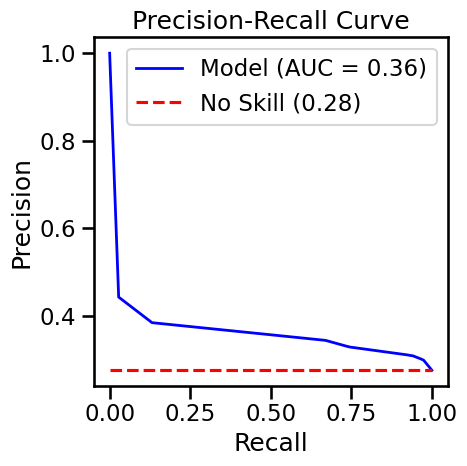

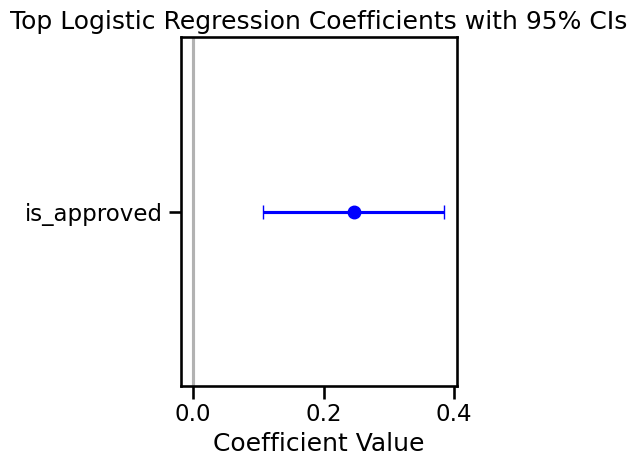

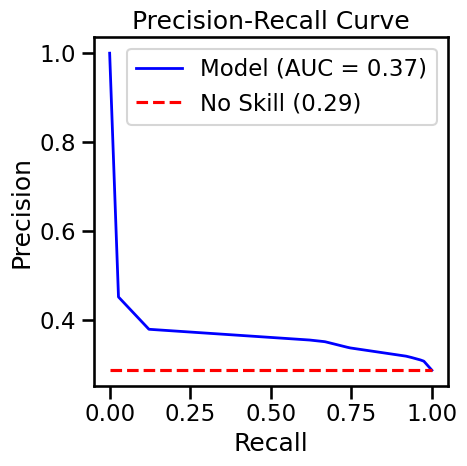

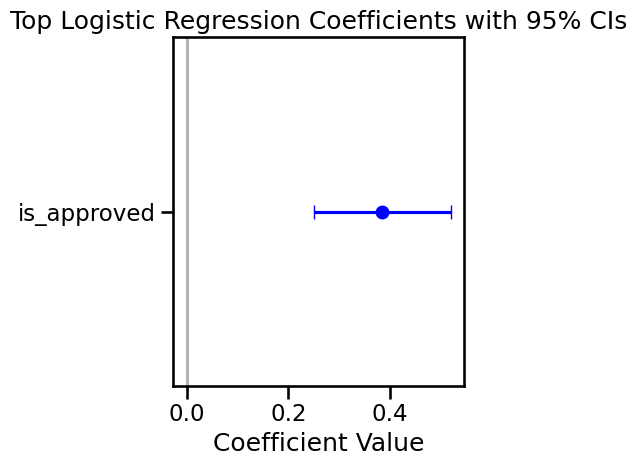

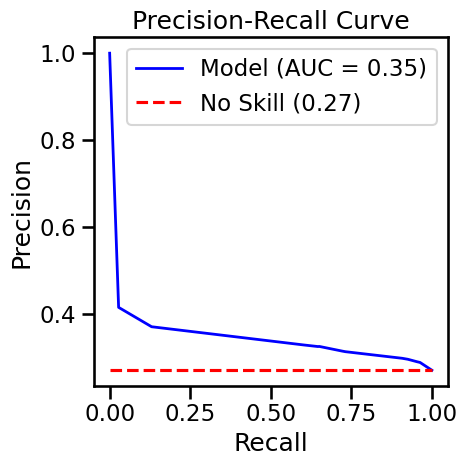

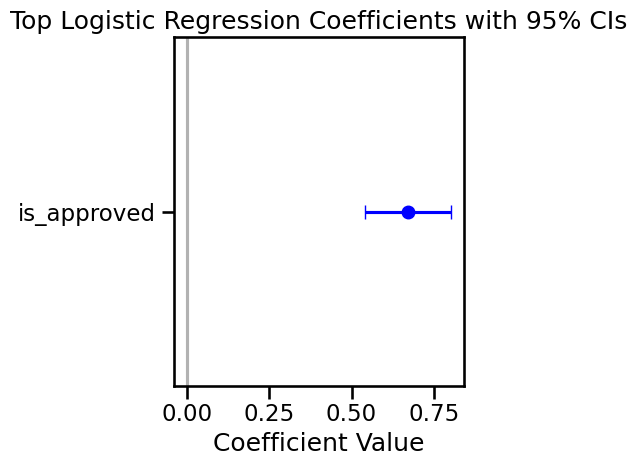

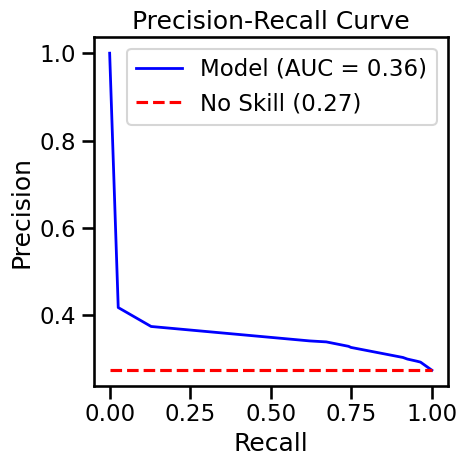

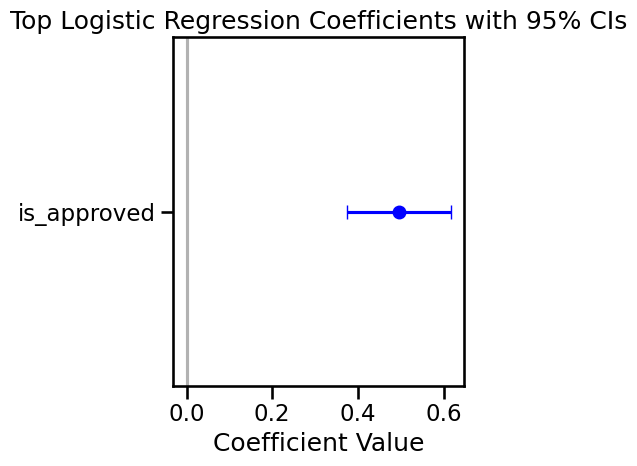

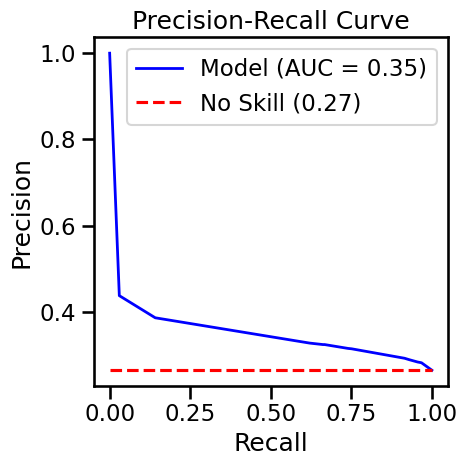

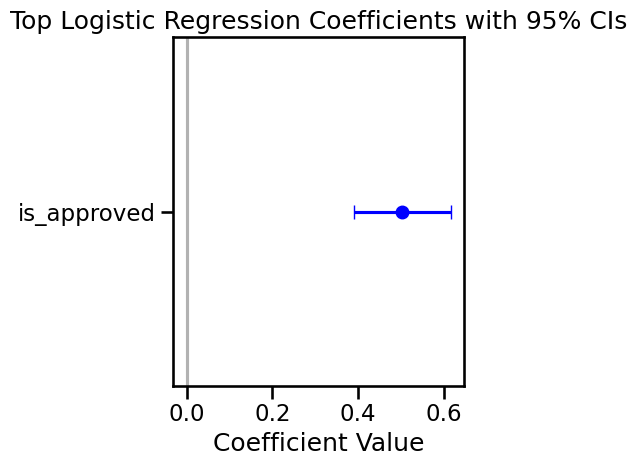

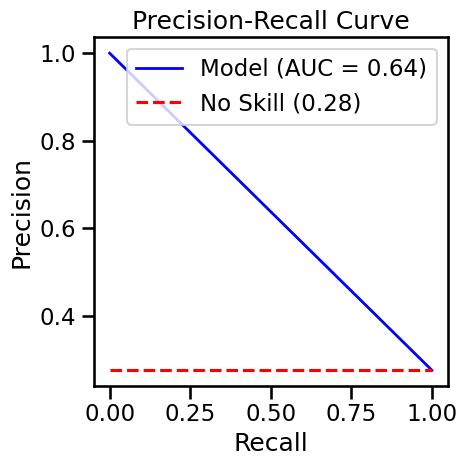

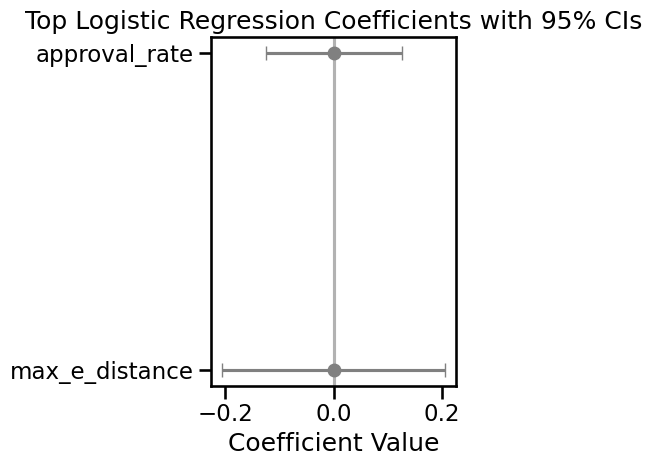

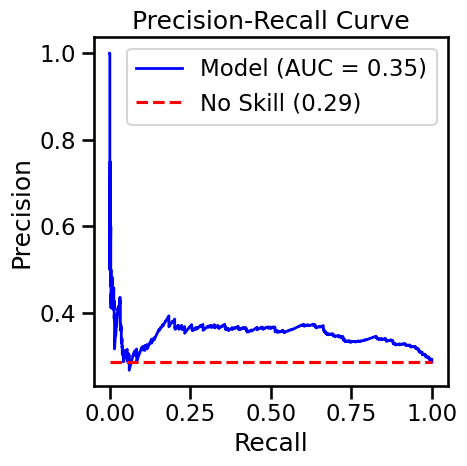

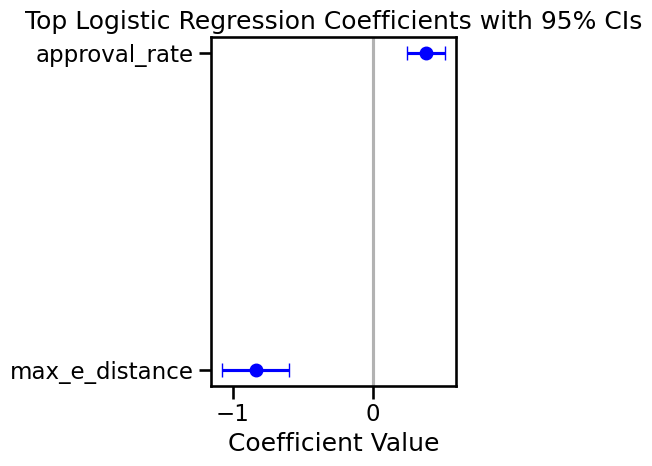

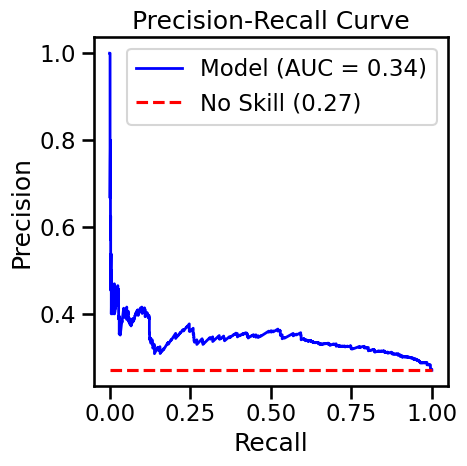

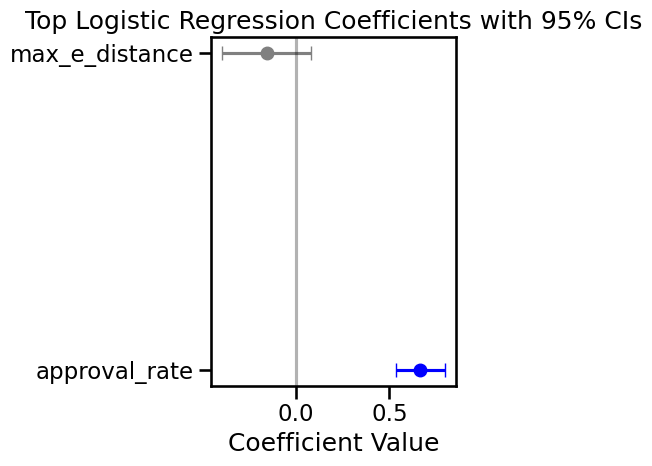

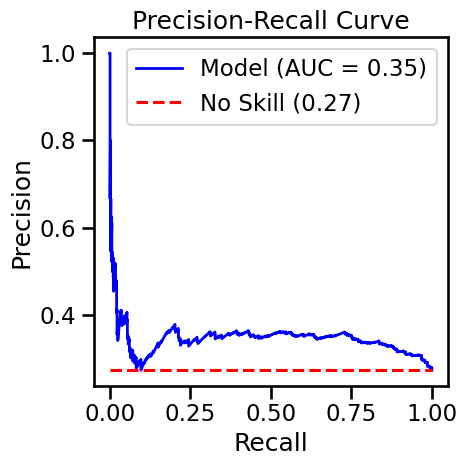

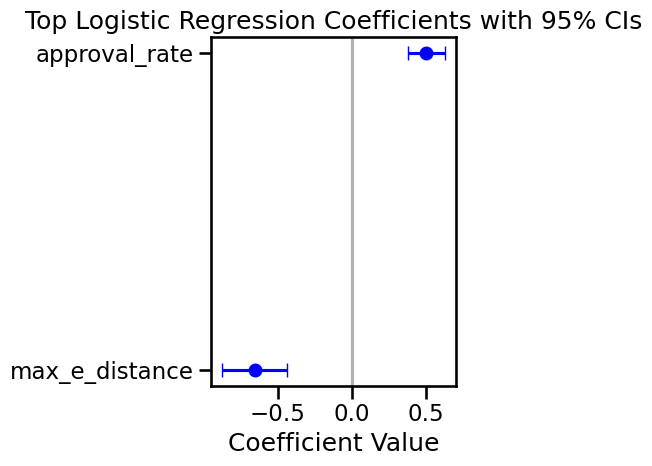

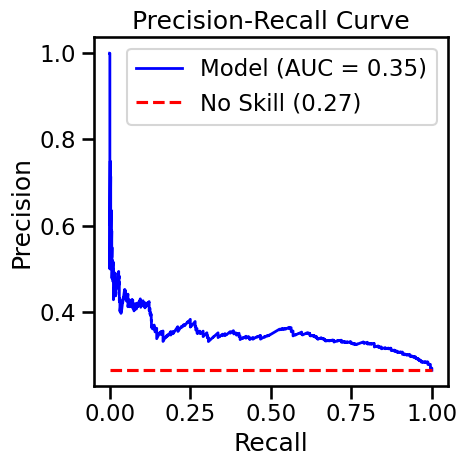

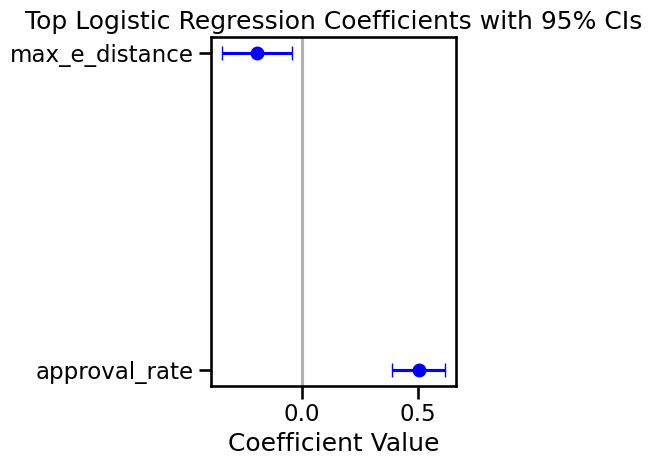

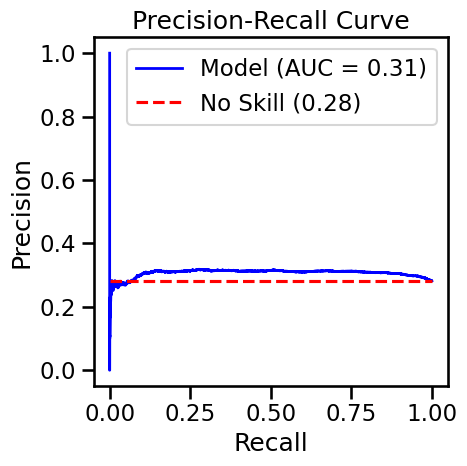

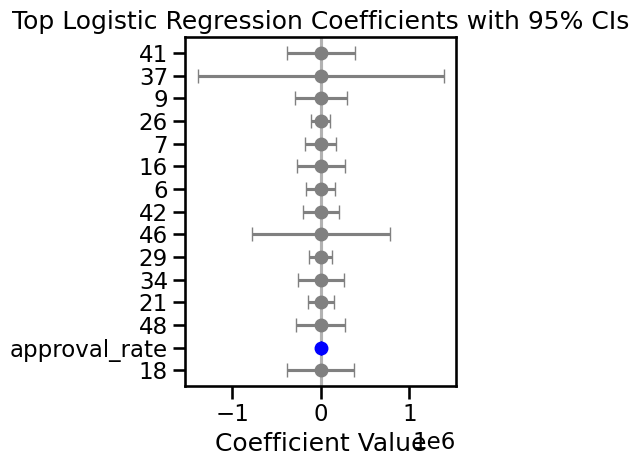

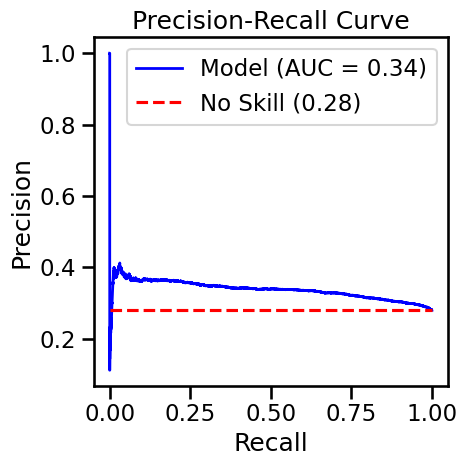

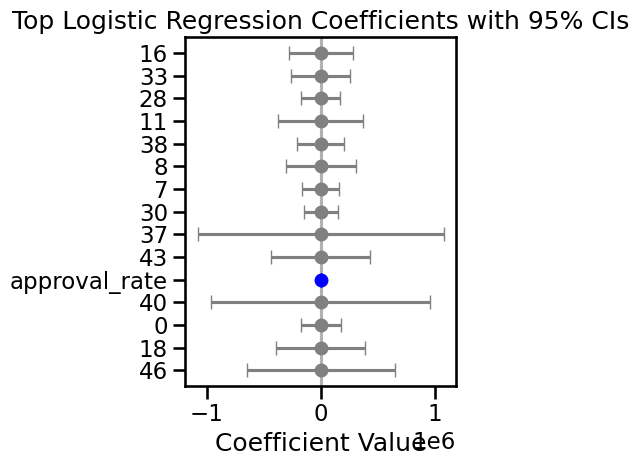

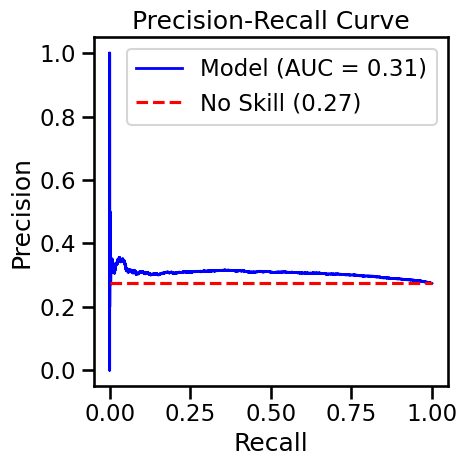

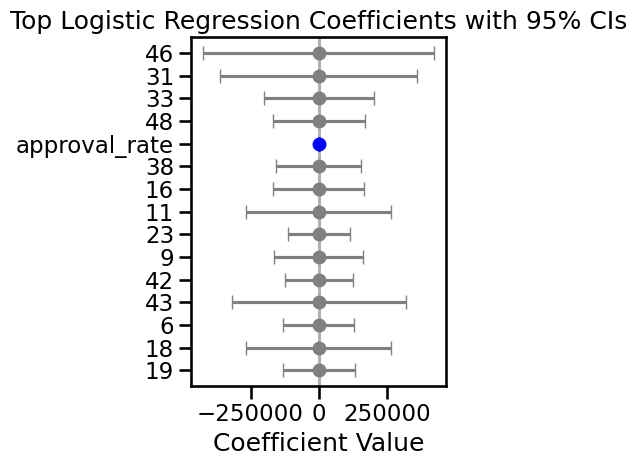

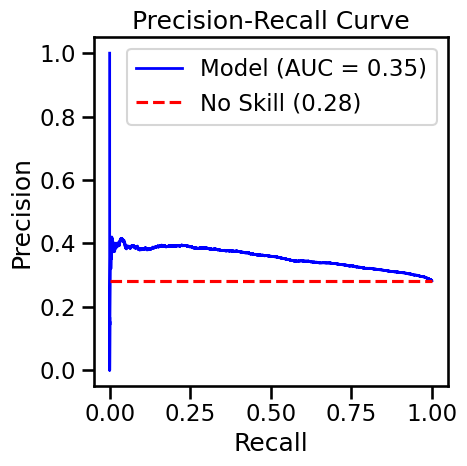

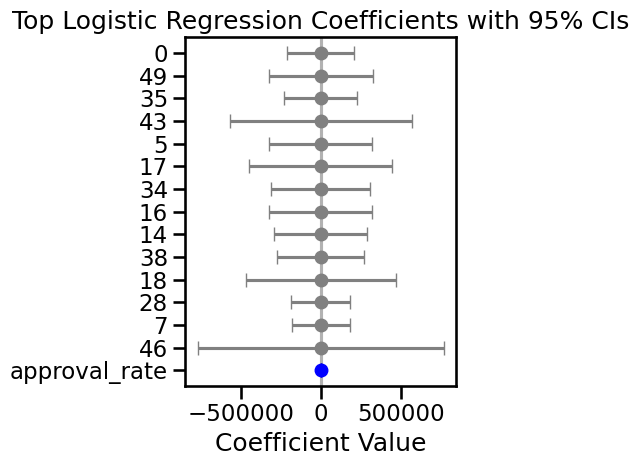

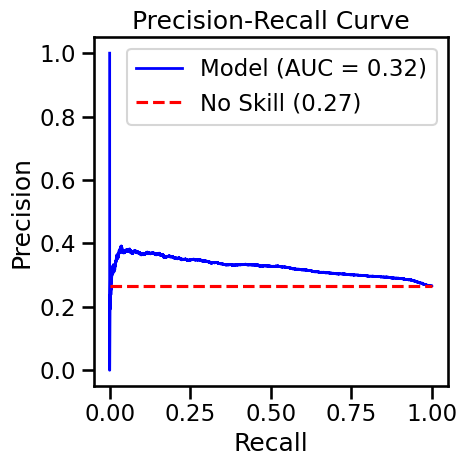

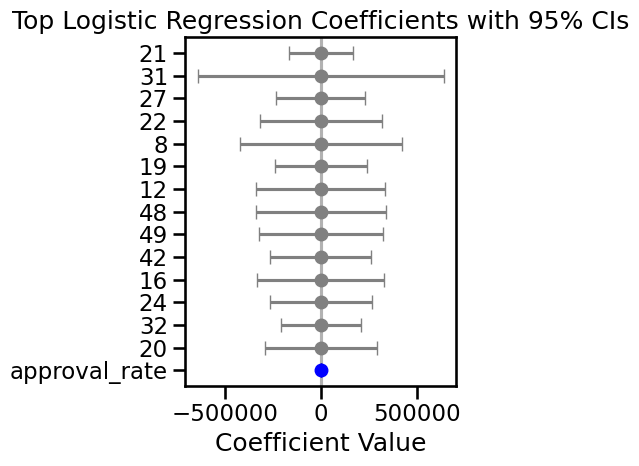

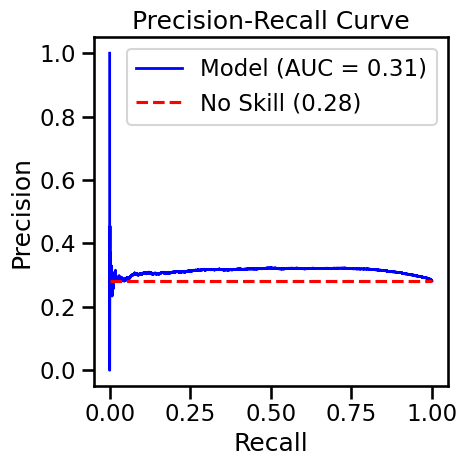

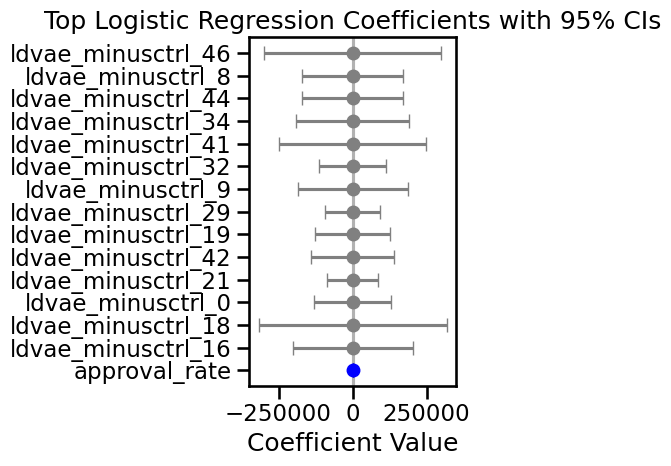

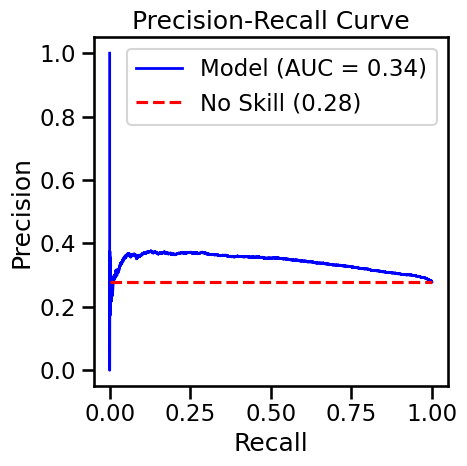

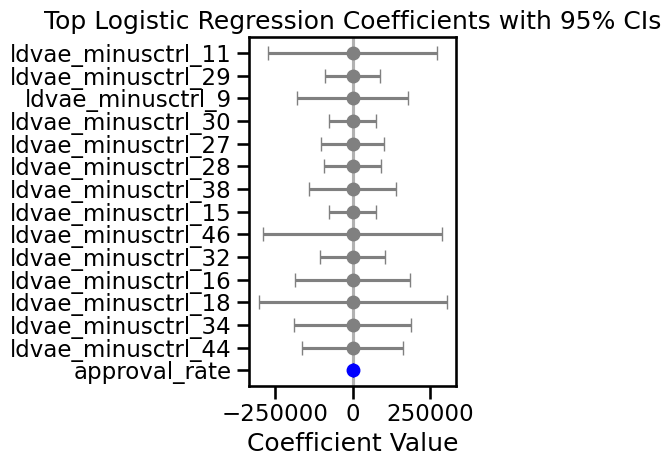

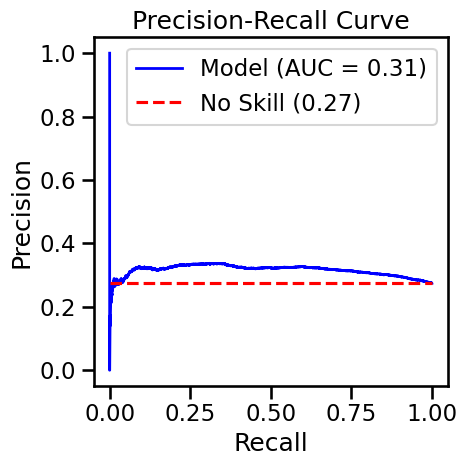

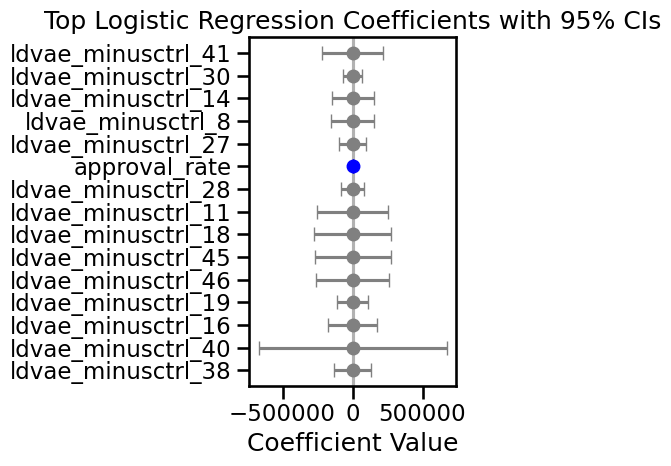

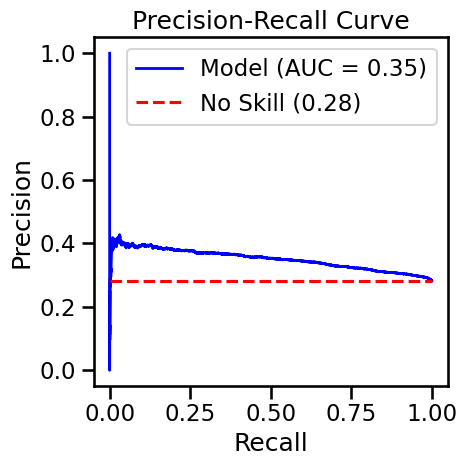

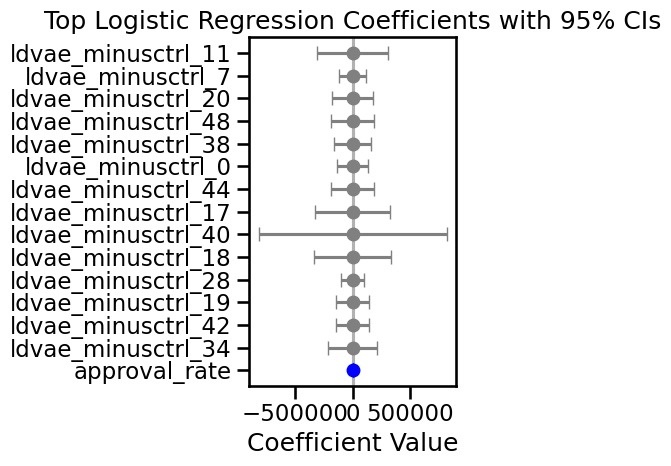

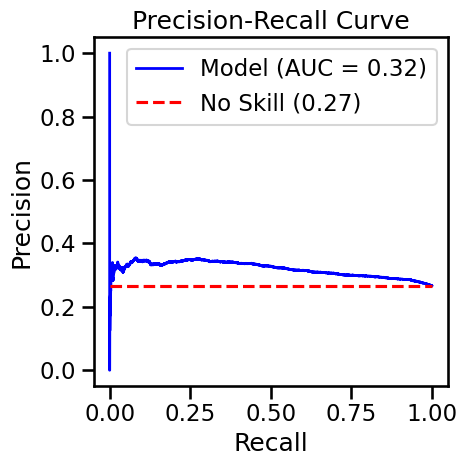

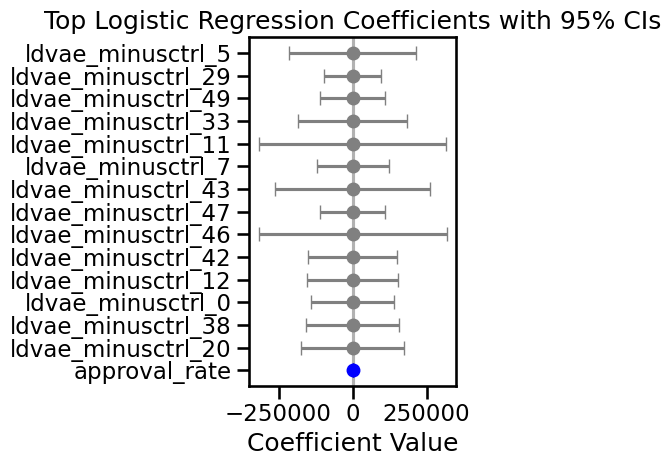

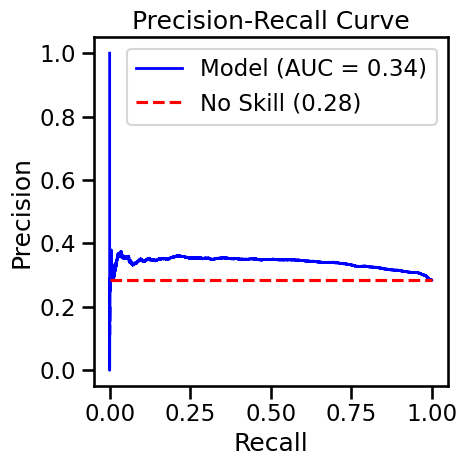

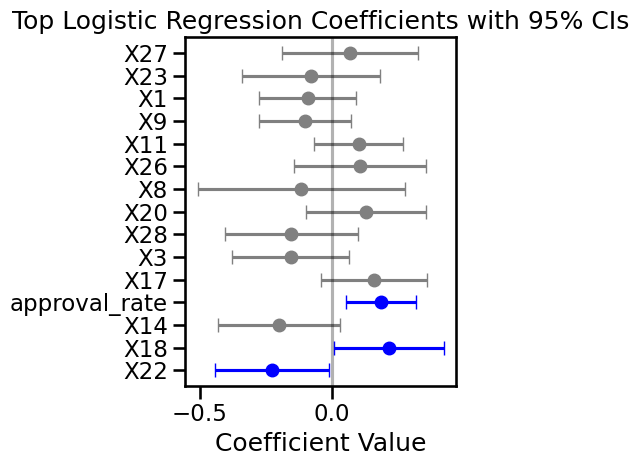

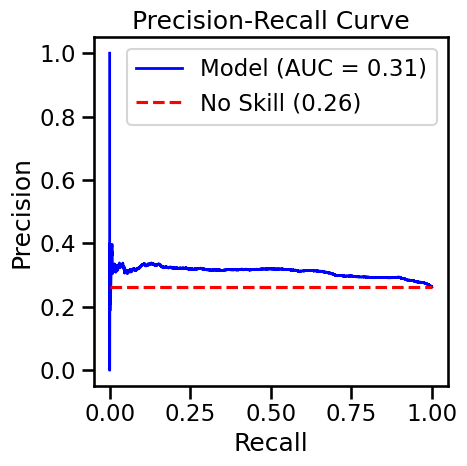

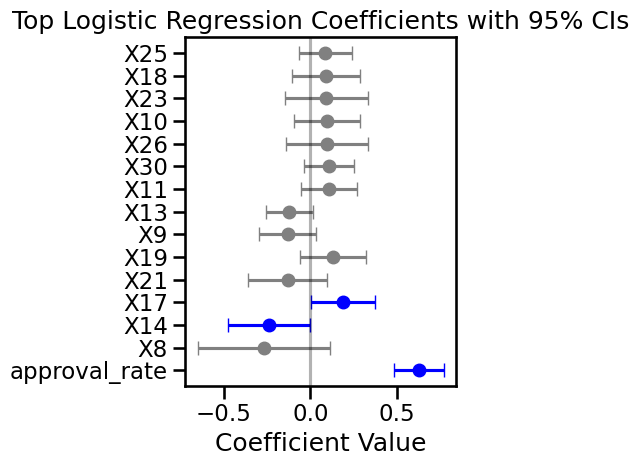

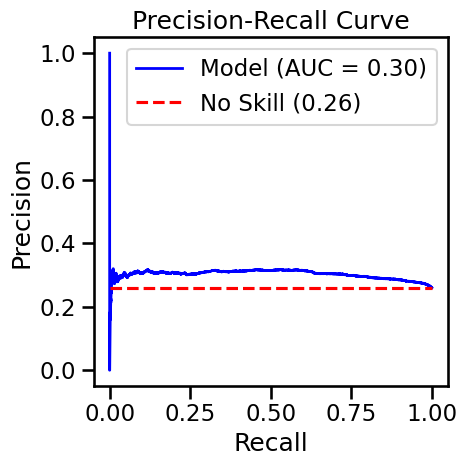

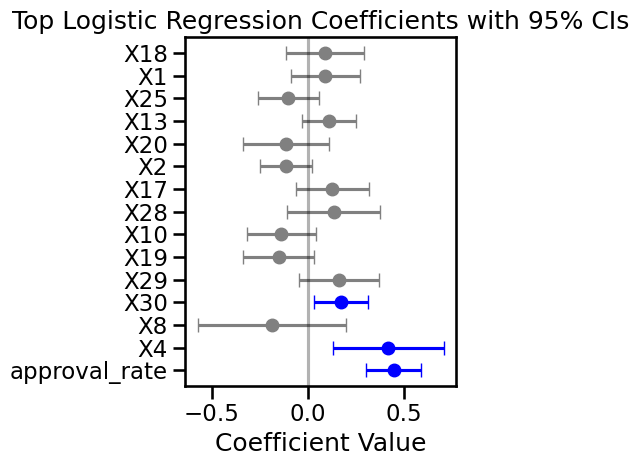

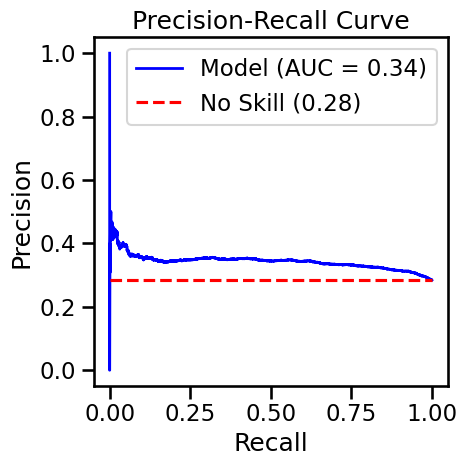

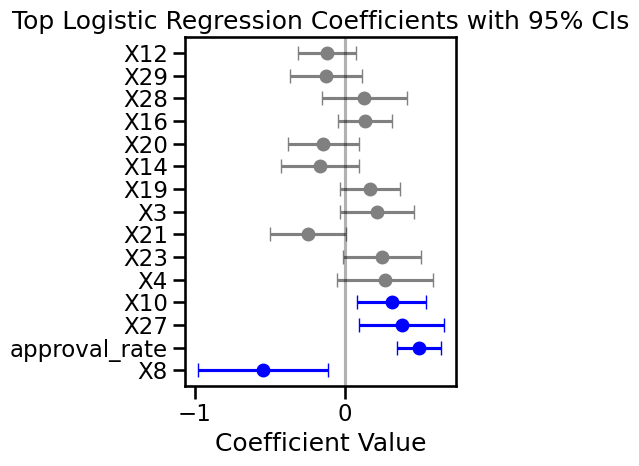

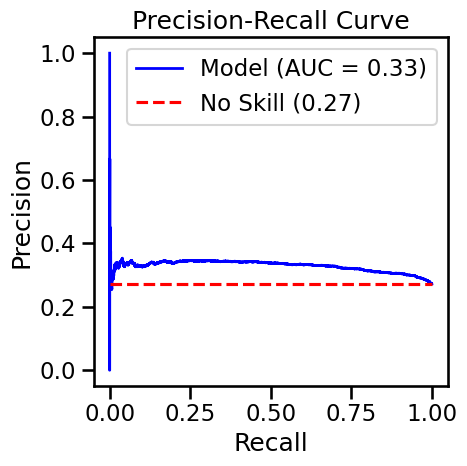

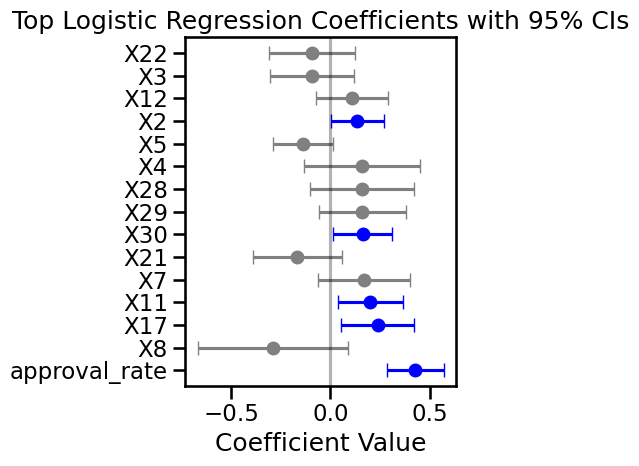

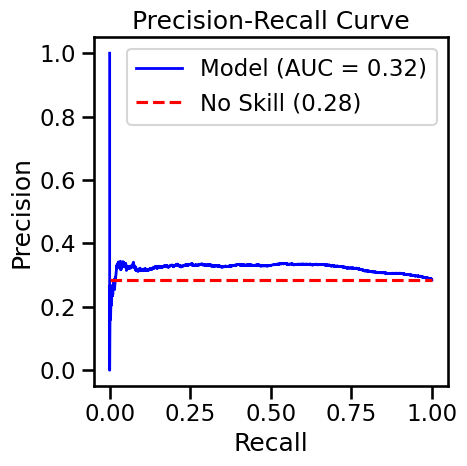

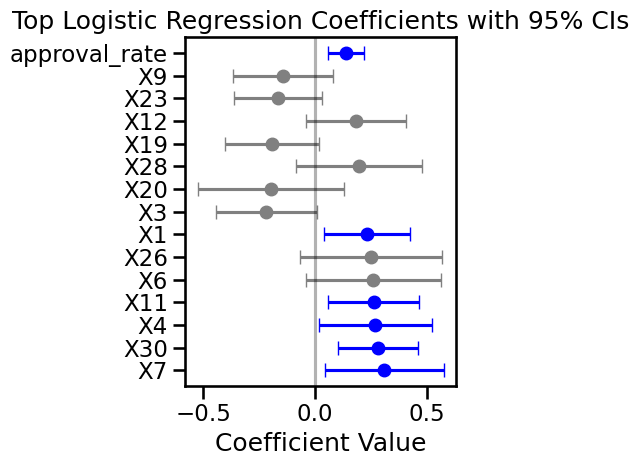

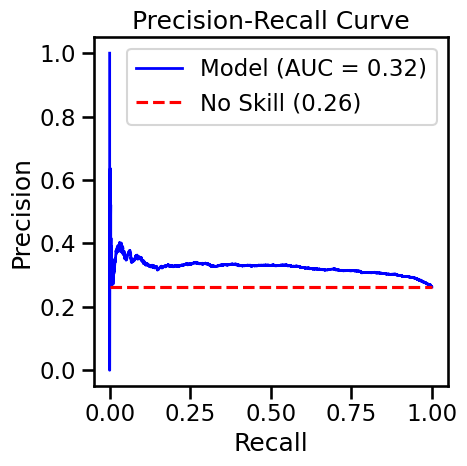

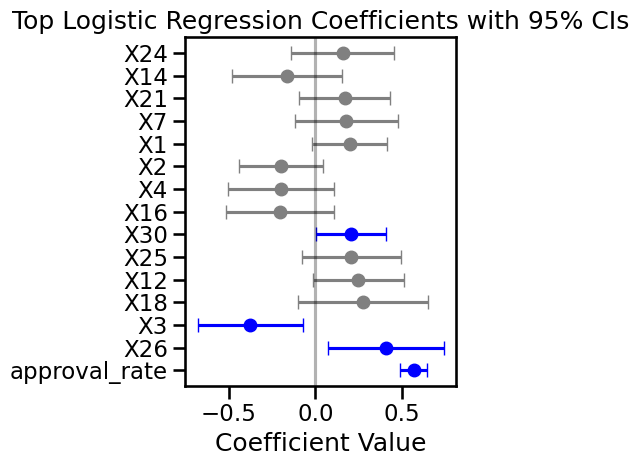

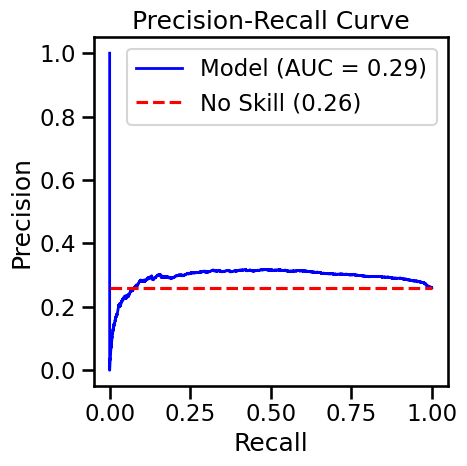

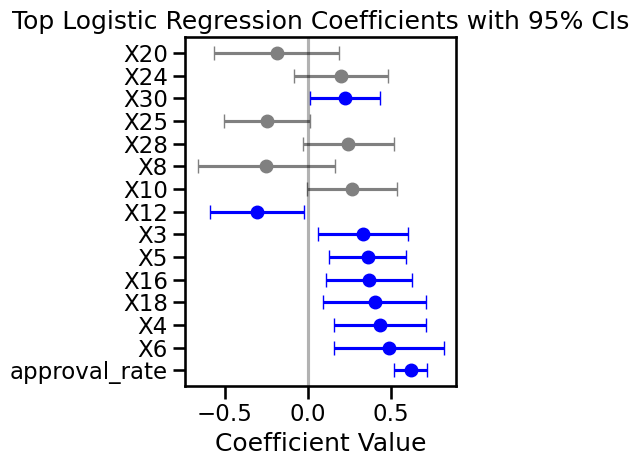

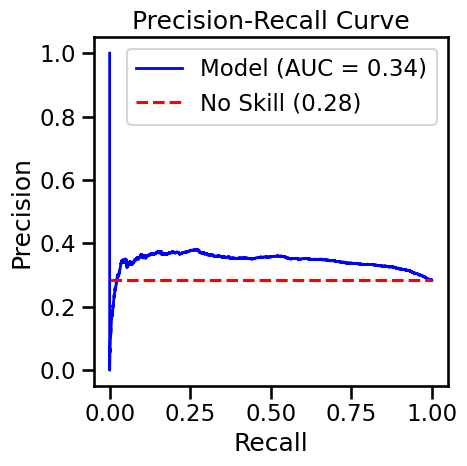

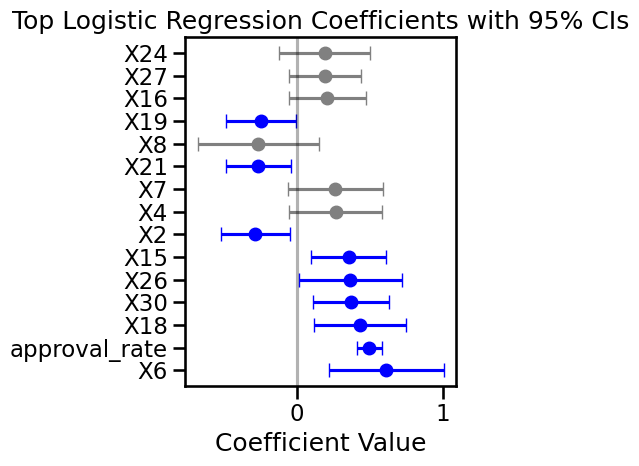

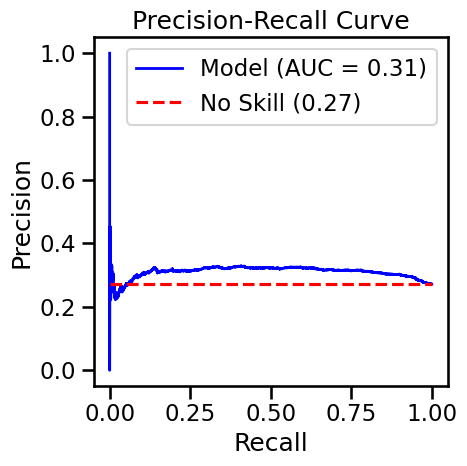

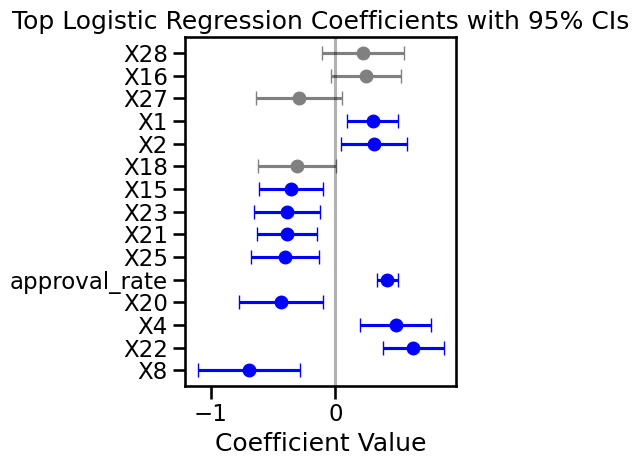

In [196]:
all_results_df = pd.DataFrame()
for k,input_features in test_features.items():
    outcomes = long_approved_df[['is_approved', 'drug_organ']]

    common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

    input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

    drug_organ_vec = input_features['drug_organ']
    outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
    outcomes.index = input_features.index

    # Convert indices to drug-cell_line
    assert outcomes.shape[0] == input_features.shape[0]
    X = input_features.drop('drug_organ', axis=1)
    y = outcomes.copy()

    # Initialize a results dataframe to store metrics for each split
    results_df = pd.DataFrame(columns=['split_seed', 'pr_auc', 'accuracy', 'pr_auc_baseline', 'n_samples'])
    
    # Initialize a dataframe to store coefficients across splits
    all_coefficients_df = pd.DataFrame()
    
    for s in [432, 43, 5235, 332, 2132]:
        X_train, X_test, y_train, y_test = prepare_data(X, y, split_seed=s)    
        lr_model = train_linear_model(X_train, y_train, alpha=0.001)    

        lr_pred, lr_prob, pr_auc, pr_auc_baseline = evaluate_model(lr_model, X_test, y_test)    
        coef_df = analyze_coefficients(lr_model, X_train.columns)
        
        # Add split seed to coefficient dataframe
        coef_df['split_seed'] = s
        
        # Save coefficients for this split
        all_coefficients_df = pd.concat([all_coefficients_df, coef_df], ignore_index=True)
        
        # Calculate accuracy for this split
        accuracy = sum(lr_pred == y_test['is_approved']) / len(y_test)
        
        # Store results in the dataframe
        new_row = pd.DataFrame({
            'split_seed': [s],
            'pr_auc': [pr_auc],
            'accuracy': [accuracy],
            'pr_auc_baseline':[pr_auc_baseline],
            'n_samples': [len(y_test)]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Display the results
    print("Results across different splits:")
    print(results_df)
    
    # Add feature type to both dataframes
    results_df['X_features'] = k
    all_coefficients_df['X_features'] = k
    
    # Save to the overall results
    all_results_df = pd.concat([all_results_df, results_df])
    
    # Save coefficients to a CSV file
    all_coefficients_df.to_csv(f'coefficients_{k}.csv', index=False)

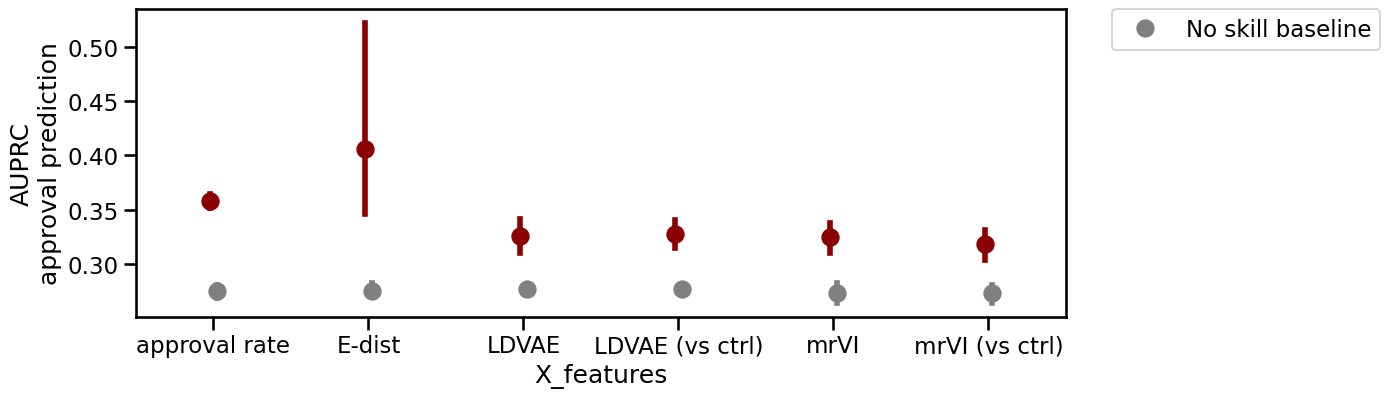

In [198]:
sns.set_context('talk')
plt.figure(figsize=(12,4))
pl_df = all_results_df.drop('accuracy', axis=1).melt(id_vars=['split_seed', 'n_samples', 'X_features'], var_name='baseline', value_name='AUPRC')
sns.pointplot(
    data=pl_df,
    x='X_features', y='AUPRC',
    hue='baseline',
    linestyles='none',
    errorbar=('ci', 95),
    dodge=True,
    palette={'pr_auc_baseline': 'grey', 'pr_auc': 'darkred'}
    );
plt.ylabel('AUPRC\napproval prediction')
# Get the current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Keep only the grey point (pr_auc_baseline) and rename it
grey_handle = handles[labels.index('pr_auc_baseline')]
plt.legend([grey_handle], ['No skill baseline'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


/tmp/ipykernel_99921/3700477978.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=pl_df, x='organ', y='max_e_distance', hue='is_approved',


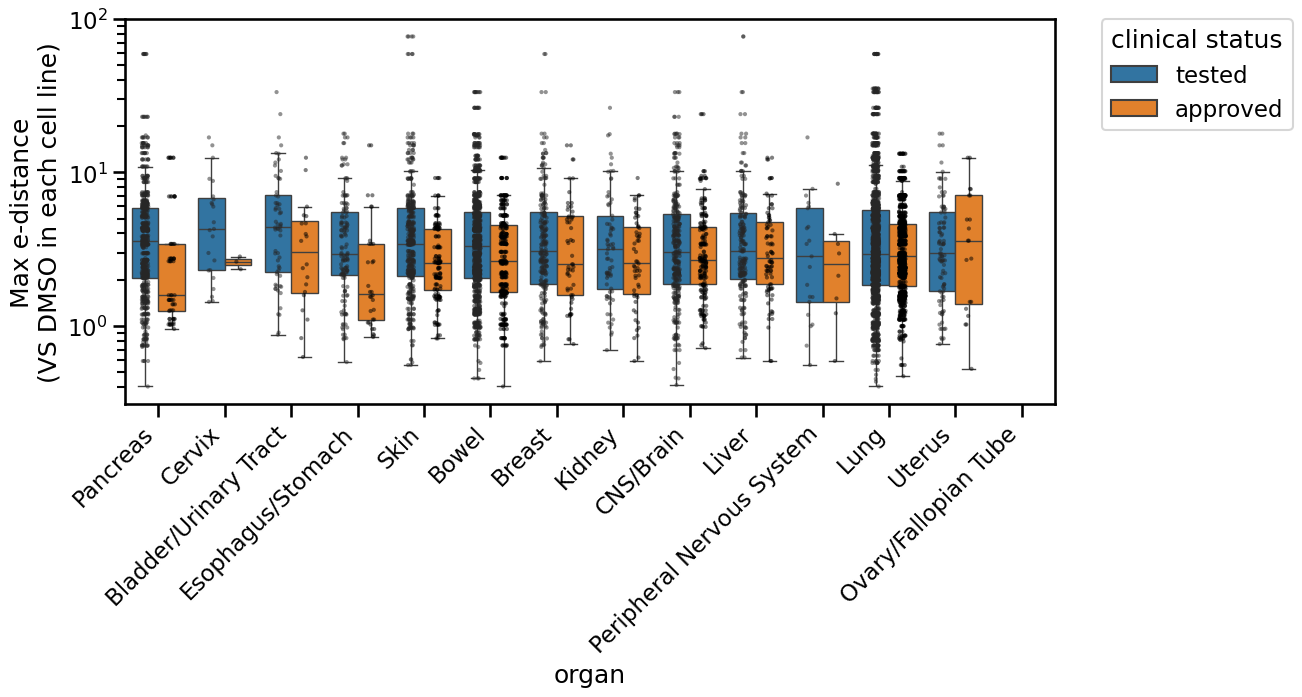

In [212]:
plt.figure(figsize=(12,5))
pl_df = pd.merge(edist_df, long_approved_df, how='right')
pl_df['organ'] = pl_df['organ'].astype(str)

# Calculate the difference in max_e_distance between approved and not approved for each organ
organ_diff = pl_df.groupby(['organ', 'is_approved'])['max_e_distance'].median().unstack()
organ_diff['difference'] = organ_diff[1] - organ_diff[0]  # approved (1) - not approved (0)

# Sort the organs by this difference
organ_order = organ_diff.sort_values('difference').index.tolist()

# Create boxplot without fliers (outliers) with sorted organs
sns.boxplot(data=pl_df, x='organ', y='max_e_distance', hue='is_approved', fliersize=0, 
            order=organ_order);
# Add stripplot with black dots, dodged by hue
sns.stripplot(data=pl_df, x='organ', y='max_e_distance', hue='is_approved', 
              dodge=True, color='black', size=3, alpha=0.5, order=organ_order);
# Set log scale for y-axis
plt.yscale('log')
plt.ylabel('Max e-distance\n(VS DMSO in each cell line)');
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
# Remove duplicate legend from stripplot
handles, labels = plt.gca().get_legend_handles_labels()
# Change legend labels: 0=tested, 1=approved
plt.legend(handles[:2], ['tested', 'approved'], title='clinical status', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Adverse effects

Top cell lines by correlation strength:
   cell_line  correlation   p_value  sample_size
10     _0546    -0.037810  0.516283          297
30     _1693    -0.041145  0.479943          297
16     _1056    -0.041856  0.472383          297
21     _1724    -0.042676  0.463748          297
44     _1731    -0.044184  0.448084          297
31     _0131    -0.044848  0.441281          297
24     _0399    -0.045162  0.438093          297
42     _0397    -0.046183  0.427795          297
36     _0293    -0.046857  0.421079          297
47     _1055    -0.047293  0.416762          297

Overall correlation: -0.0542, p-value: 3.7095e-11


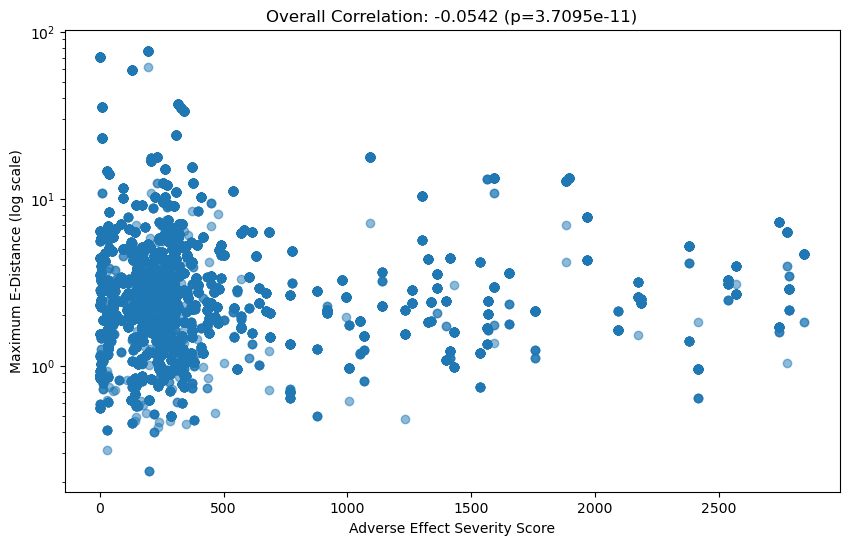

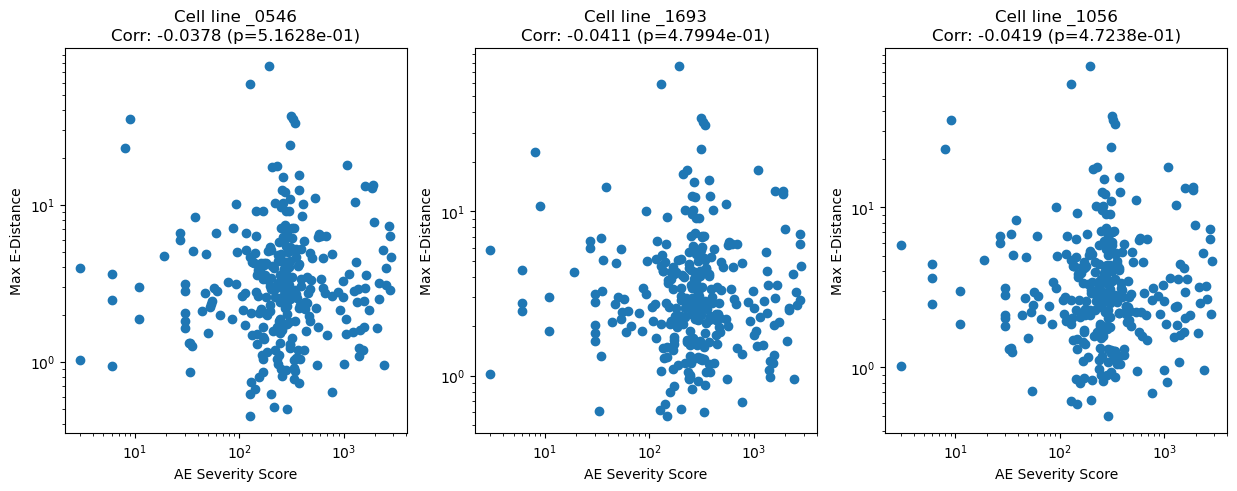

In [84]:
edist_df['drug'] = edist_df['drug_organ'].str.split("_").str[0]
edist_df['cell_line'] = edist_df.reset_index()['drug-cell_line'].str.split("_CVCL").str[1].values
# drug_edist = edist_df.groupby('drug')['max_e_distance'].mean()
# drug_edist = drug_edist.reset_index()

ae_severity = pd.read_csv('./data_for_classifier/tahoe_drug_ae_severity_score.csv', index_col=0)
ae_severity = ae_severity.reset_index().rename({'drug_name':'drug'}, axis=1)

pl_df = pd.merge(ae_severity, edist_df)
pl_df
from scipy.stats import pearsonr

# Analyze correlation for each cell line
cell_line_correlations = []
for cell_line in pl_df['cell_line'].unique():
    cell_data = pl_df[pl_df['cell_line'] == cell_line]
    
    # Only calculate if we have enough data points
    if len(cell_data) > 5:  # Minimum sample size for meaningful correlation
        correlation, p_value = pearsonr(cell_data['ae_severity_score'], cell_data['max_e_distance'])
        cell_line_correlations.append({
            'cell_line': cell_line,
            'correlation': correlation,
            'p_value': p_value,
            'sample_size': len(cell_data)
        })

# Convert to DataFrame for easier analysis
cell_corr_df = pd.DataFrame(cell_line_correlations)
cell_corr_df = cell_corr_df.sort_values('correlation', ascending=False)

# Display top correlations
print("Top cell lines by correlation strength:")
print(cell_corr_df.head(10))

# Calculate overall correlation for comparison
overall_correlation, overall_p_value = pearsonr(pl_df['ae_severity_score'], pl_df['max_e_distance'])
print(f"\nOverall correlation: {overall_correlation:.4f}, p-value: {overall_p_value:.4e}")

# Create scatter plot for overall correlation
plt.figure(figsize=(10, 6))
plt.scatter(pl_df['ae_severity_score'], pl_df['max_e_distance'], alpha=0.5)
plt.yscale('log')
# plt.xscale('log')
plt.title(f'Overall Correlation: {overall_correlation:.4f} (p={overall_p_value:.4e})')
plt.xlabel('Adverse Effect Severity Score')
plt.ylabel('Maximum E-Distance (log scale)')

# Create scatter plots for top 3 cell lines with strongest correlations
if len(cell_corr_df) >= 3:
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(cell_corr_df.head(3).iterrows()):
        cell_data = pl_df[pl_df['cell_line'] == row['cell_line']]
        plt.subplot(1, 3, i+1)
        plt.scatter(cell_data['ae_severity_score'], cell_data['max_e_distance'])
        plt.yscale('log')
        plt.xscale('log')
        plt.title(f"Cell line {row['cell_line']}\nCorr: {row['correlation']:.4f} (p={row['p_value']:.4e})")
        plt.xlabel('AE Severity Score')
        plt.ylabel('Max E-Distance')


In [ ]:
cell_corr_df

cell_line  correlation   p_value  sample_size
10     _0546    -0.037810  0.516283          297
30     _1693    -0.041145  0.479943          297
16     _1056    -0.041856  0.472383          297
21     _1724    -0.042676  0.463748          297
44     _1731    -0.044184  0.448084          297
31     _0131    -0.044848  0.441281          297
24     _0399    -0.045162  0.438093          297
42     _0397    -0.046183  0.427795          297
36     _0293    -0.046857  0.421079          297
47     _1055    -0.047293  0.416762          297
49     _0480    -0.047410  0.415610          297
12     _0332    -0.048412  0.405809          297
40     _0218    -0.048579  0.404190          297
3      _0371    -0.049654  0.393863          297
4      _0459    -0.050413  0.386662          297
18     _1550    -0.050592  0.384979          297
37     _0504    -0.051077  0.380430          297
23     _1635    -0.051303  0.378327          297
20     _1285    -0.051444  0.377013          297
5      _1125    -0.051512  0.376381          297
26     _1717    -0.051837  0.373370          297
8      _1666    -0.051945  0.372375          297
29     _1119    -0.052416  0.368054          297
25     _1097    -0.052782  0.364714          297
27     _0152    -0.053340  0.359659          297
7      _1517    -0.054592  0.348471          297
43     _0366    -0.054759  0.346996          297
38     _0292    -0.054875  0.345975          297
15     _1478    -0.054961  0.345225          297
19     _1239    -0.055025  0.344662          297
39     _0359    -0.055381  0.341541          297
34     _1547    -0.055698  0.338782          297
33     _0179    -0.057175  0.326106          297
11     _1577    -0.057372  0.324439          297
14     _0428    -0.058225  0.317290          297
41     _0320    -0.059585  0.306097          297
46     _1098    -0.060221  0.300956          297
45     _1716    -0.060345  0.299959          297
32     _0023    -0.060755  0.296682          297
22     _0334    -0.060941  0.295203          297
28     _0069    -0.062065  0.286364          297
6      _C466    -0.062336  0.284260          297
17     _1495    -0.062373  0.283975          297
35     _1094    -0.064065  0.271093          297
1      _1571    -0.064371  0.268802          297
13     _1531    -0.065030  0.263926          297
2      _0099    -0.066200  0.255407          297
0      _1381    -0.066742  0.251528          297
48     _0028    -0.067185  0.248392          297
9      _1715    -0.071727  0.217766          297

## Depmap scores

In [20]:
depmap_dependency = pd.read_table('./data_for_classifier/depmap_dependency_scores.tsv', index_col=0)
depmap_dependency['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[depmap_dependency.index]['drug_organ']
depmap_dependency = depmap_dependency.groupby('drug_organ').mean().reset_index()
depmap_dependency['depmap_dependency_score'] = depmap_dependency['depmap_dependency_score'] > 0.5

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5034295201971858
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Model training Precision-Recall AUC: 0.5232
Model training ROC AUC: 0.7113
Regularization: alpha=0.001

ROC AUC: 0.4760
Baseline ROC AUC: 0.5000
PR AUC: 0.1092
Baseline PR AUC: 0.1146


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance     0.630986  2.638828e-58    1.879463   

                CI_Lower_95  CI_Upper_95  
max_e_distance     0.554162      0.70781  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18311748739153805
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Model training Precision-Recall AUC: 0.2634
Model training ROC AUC: 0.9039
Regularization: alpha=0.001

ROC AUC: 0.4944
Baseline ROC AUC: 0.5000
PR AUC: 0.2315
Baseline PR AUC: 0.1613


/tmp/ipykernel_99921/1471829481.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, C


Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance     6.218775  1.333616e-33   502.08794   

                CI_Lower_95  CI_Upper_95  
max_e_distance     5.209857     7.227694  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3514100522497421
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.1930
Model training ROC AUC: 0.6937
Regularization: alpha=0.001

ROC AUC: 0.3926
Baseline ROC AUC: 0.5000
PR AUC: 0.1235
Baseline PR AUC: 0.1471

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -2.718562  3.247961e-12     0.06597   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -3.483399    -1.953724  

Numb

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4292917750430502
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.1095
Model training ROC AUC: 0.3324
Regularization: alpha=0.001

ROC AUC: 0.4798
Baseline ROC AUC: 0.5000
PR AUC: 0.1466
Baseline PR AUC: 0.1412

Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 1


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5431856642927236
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.6173
Model training ROC AUC: 0.5000
Regularization: alpha=0.001

ROC AUC: 0.5000
Baseline ROC AUC: 0.5000
PR AUC: 0.5607
Baseline PR AUC: 0.1213

Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 1


/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.109217  0.847638         0.114621      3577
1         43  0.231497  0.703942         0.161308      3577
2       5235  0.123545  0.852949         0.147051      3577
3        332  0.146585  0.858820         0.141180      3577
4       2132  0.560665  0.878669         0.121331      3577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04931434199491006
            Iterations: 522
            Function evaluations: 523
            Gradient evaluations: 522
Model training Precision-Recall AUC: 0.3068
Model training ROC AUC: 0.9587
Regularization: alpha=0.001

ROC AUC: 0.5241
Baseline ROC AUC: 0.5000
PR AUC: 0.2348
Baseline PR AUC: 0.1932

Top significant features (p < 0.05):
    Feature  Coefficient       p_value    Odds_Ratio  CI_Lower_95  CI_Upper_95
X12     X12   -13.601275  4.409545e-07      0.000001   -18.879702    -8.322848
X9       X9  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1471829481.py:39: Fut

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5282214995970997
            Iterations: 326
            Function evaluations: 327
            Gradient evaluations: 326
Model training Precision-Recall AUC: 0.2791
Model training ROC AUC: 0.5691
Regularization: alpha=0.001

ROC AUC: 0.5270
Baseline ROC AUC: 0.5000
PR AUC: 0.1600
Baseline PR AUC: 0.1447

Top significant features (p < 0.05):
    Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X23     X23    -0.444281  0.036587    0.641285    -0.860850    -0.027711
X13     X13    -0.274033  0.019779    0.760307    -0.504496    -0.043570

Number of significant coefficients (p < 0.05): 2 out of 30


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 9 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4433498620996165
            Iterations: 123
            Function evaluations: 124
            Gradient evaluations: 123
Model training Precision-Recall AUC: 0.3877
Model training ROC AUC: 0.6764
Regularization: alpha=0.001

ROC AUC: 0.5444
Baseline ROC AUC: 0.5000
PR AUC: 0.1729
Baseline PR AUC: 0.1524

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X8       X8     1.573508  6.786786e-06    4.823542     0.888211     2.258805
X4       X4    -1.154150  2.742094e-05    0.315325    -1.693529    -0.614772
X23     X23    -1.061472  1.615642e-07    0.345946    -1.458590    -0.664354
X21     X21     0.928933  4.377495e-07    2.531806     0.568529     1.289337
X11     X11    -0.792025  2.524843e-06    0.452927    -1.121881    -0.462169
X25     X25     0.726480  1.901815e-06    2.067788     0.427572     1.025387
X28     X28    -0.692877  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3848490555692486
            Iterations: 137
            Function evaluations: 138
            Gradient evaluations: 137
Model training Precision-Recall AUC: 0.2230
Model training ROC AUC: 0.6237
Regularization: alpha=0.001

ROC AUC: 0.4447
Baseline ROC AUC: 0.5000
PR AUC: 0.1453
Baseline PR AUC: 0.1648

Top significant features (p < 0.05):
    Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X3       X3    -0.617600  0.002454    0.539237    -1.017238    -0.217962
X26     X26     0.551068  0.012172    1.735106     0.120264     0.981873
X18     X18     0.539424  0.006178    1.715019     0.153307     0.925541
X20     X20     0.505612  0.009532    1.658000     0.123343     0.887881
X22     X22    -0.406837  0.025867    0.665753    -0.764698    -0.048975
X6       X6     0.371611  0.013160    1.450069     0.077855     0.665368
X12     X12     0.358030  0.028009    1.430508     0.0

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05368975896178495
            Iterations: 351
            Function evaluations: 351
            Gradient evaluations: 351
Model training Precision-Recall AUC: 0.2919
Model training ROC AUC: 0.9440
Regularization: alpha=0.001

ROC AUC: 0.5320
Baseline ROC AUC: 0.5000
PR AUC: 0.2380
Baseline PR AUC: 0.1920

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X12     X12   -10.314658  1.583716e-07    0.000033   -14.170865    -6.458452
X9       X9    -7.449219  1.250061e-07    0.000582   -10.211260    -4.687179
X23     X23     6.482829  2.602516e-04  653.818227     3.003566     9.962093
X10     X10     6.228429  1.131335e-05  506.958562     3.447942     9.008916
X22     X22     5.897590  5.624900e-08  364.158932     3.768980     8.026201
X2       X2    -5.403972  1.915620e-06    0.004499    -7.628101    -3.179842
X28     X28     4.280468 

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.234797  0.806959         0.193164      8133
1         43  0.160033  0.855325         0.144675      8329
2       5235  0.172874  0.840915         0.152447      8134
3        332  0.145283  0.835221         0.164779      8035
4       2132  0.238031  0.807504         0.192007      8182


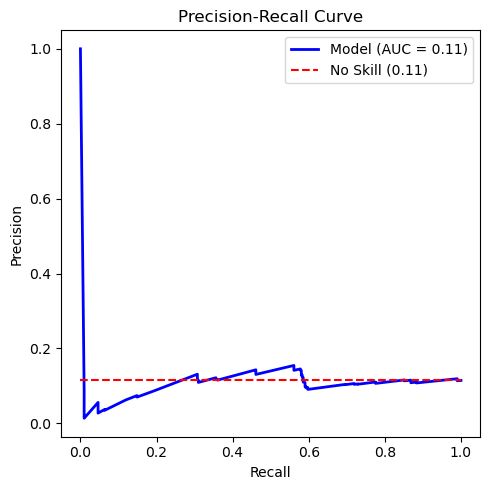

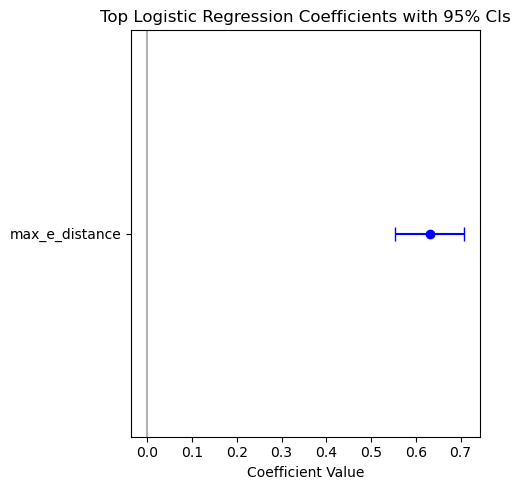

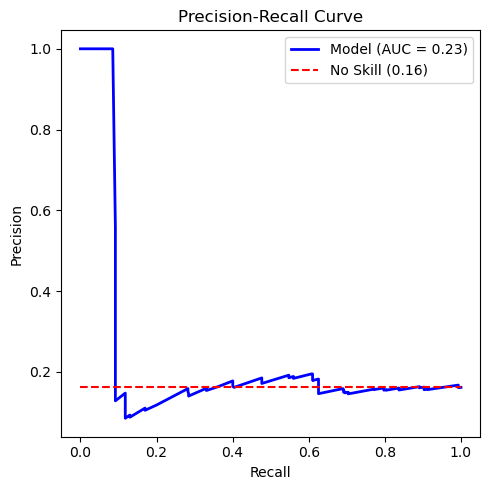

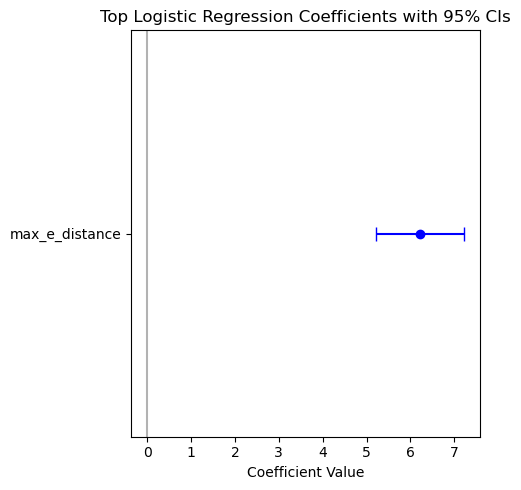

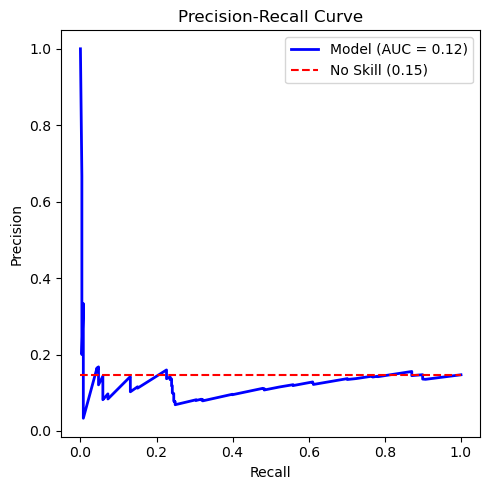

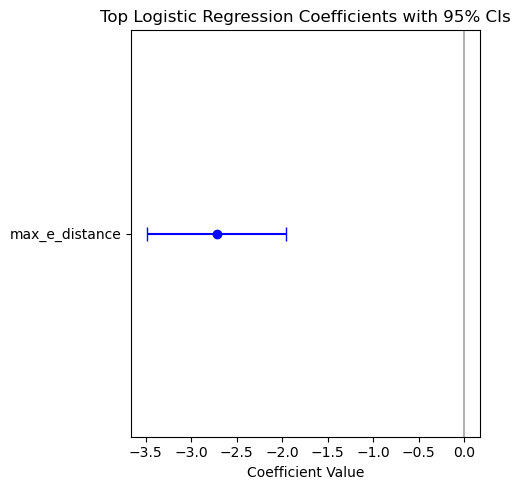

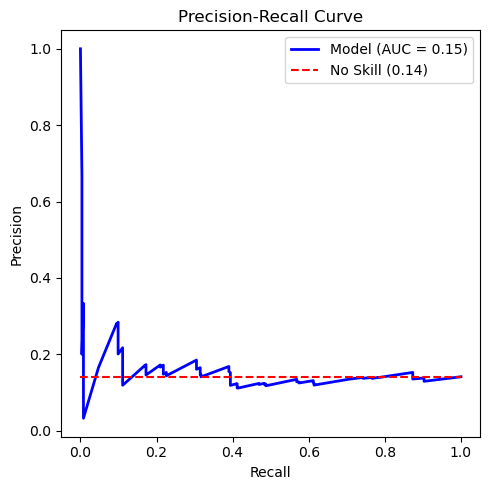

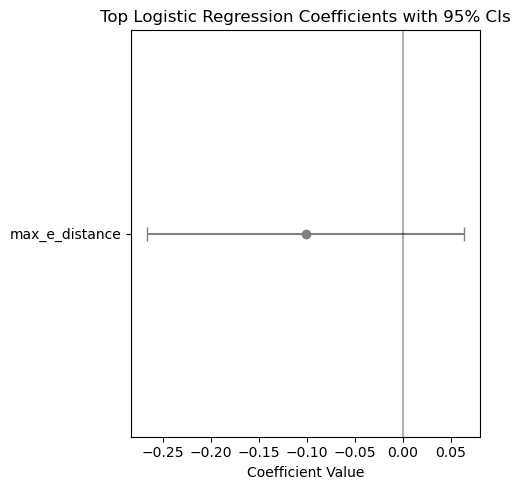

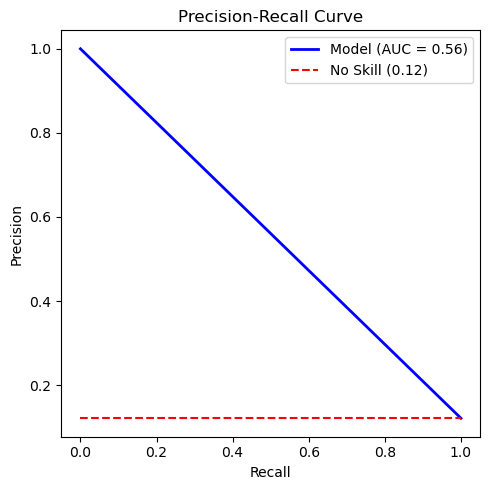

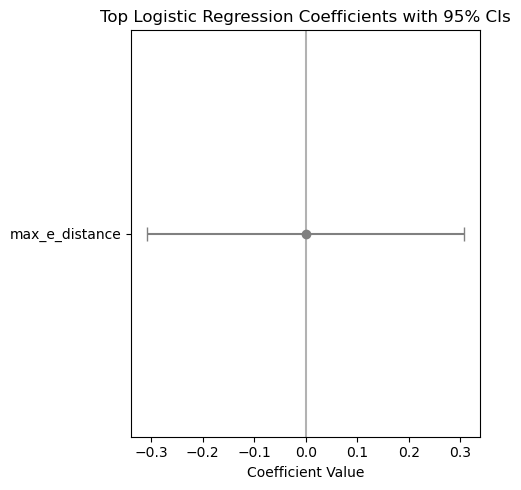

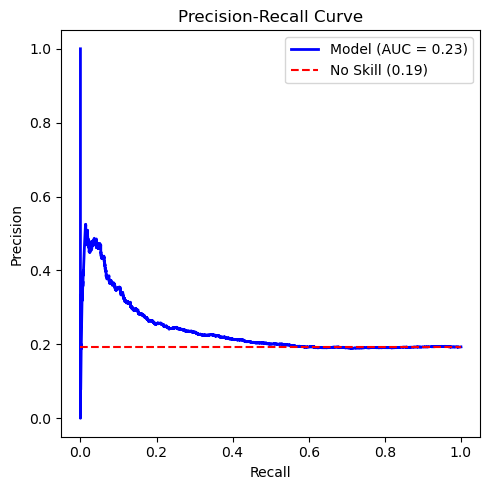

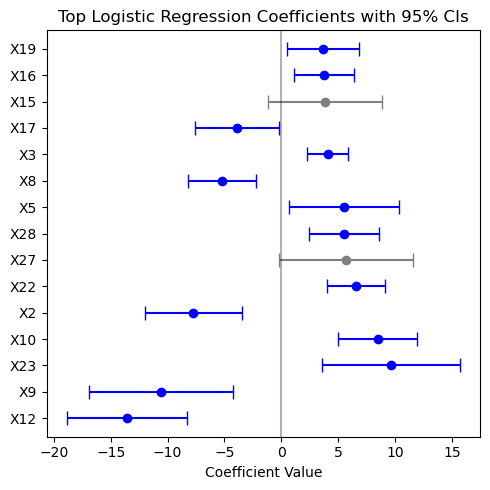

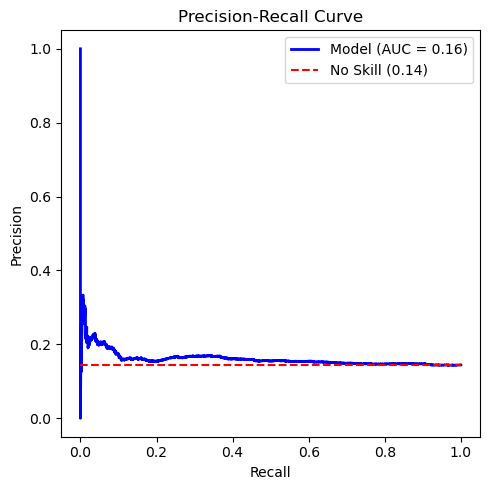

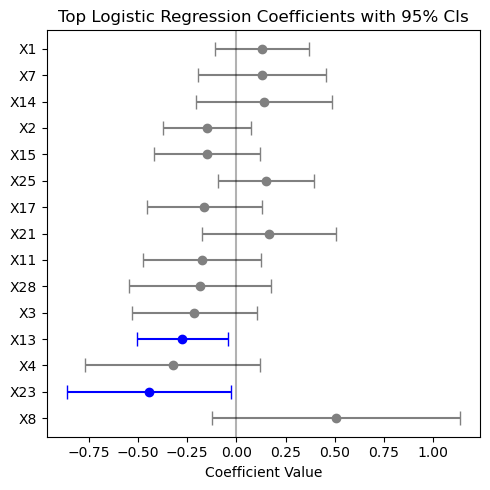

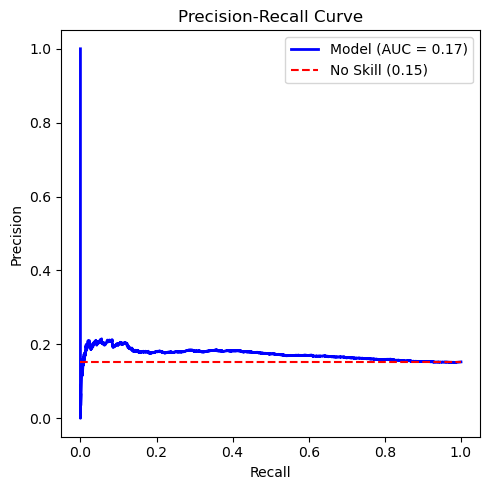

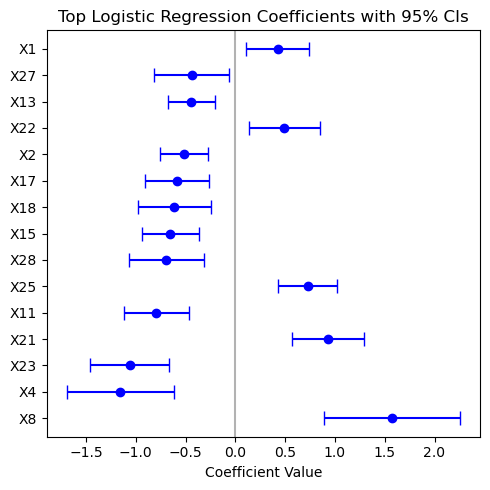

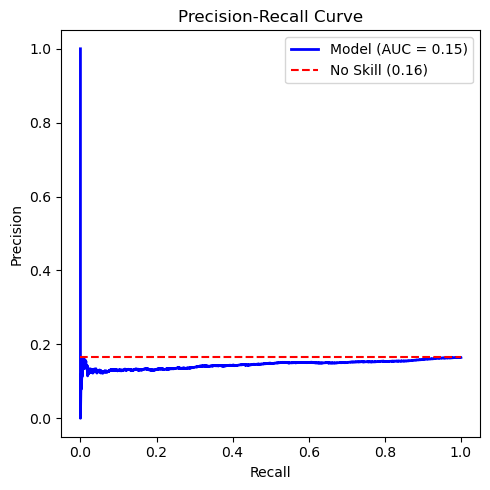

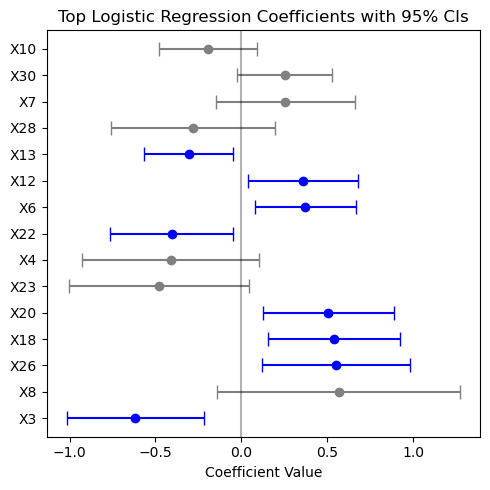

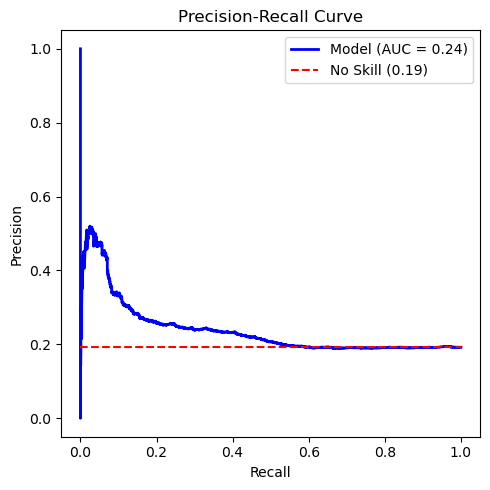

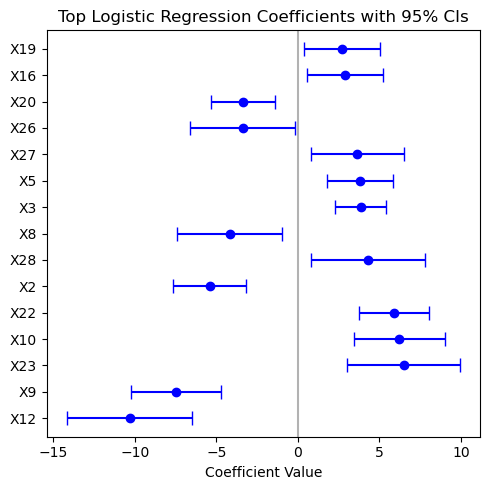

In [21]:
all_results_df = pd.DataFrame()
for k,input_features in test_features.items():
    outcomes = depmap_dependency

    common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

    input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

    drug_organ_vec = input_features['drug_organ']
    outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
    outcomes.index = input_features.index

    # Convert indices to drug-cell_line
    assert outcomes.shape[0] == input_features.shape[0]
    X = input_features.drop('drug_organ', axis=1)
    y = outcomes.copy()

    # Initialize a results dataframe to store metrics for each split
    results_df = pd.DataFrame(columns=['split_seed', 'pr_auc', 'accuracy', 'pr_auc_baseline', 'n_samples'])

    for s in [432, 43, 5235, 332,2132]:
        X_train, X_test, y_train, y_test = prepare_data(X, y, split_seed=s)    
        lr_model = train_linear_model(X_train, y_train, alpha=0.001)    

        lr_pred, lr_prob, pr_auc, pr_auc_baseline = evaluate_model(lr_model, X_test, y_test)    
        coef_df = analyze_coefficients(lr_model, X_train.columns)
        
        # Calculate accuracy for this split
        accuracy = sum(lr_pred == y_test['depmap_dependency_score']) / len(y_test)
        
        # Store results in the dataframe
        new_row = pd.DataFrame({
            'split_seed': [s],
            'pr_auc': [pr_auc],
            'accuracy': [accuracy],
            'pr_auc_baseline':[pr_auc_baseline],
            'n_samples': [len(y_test)]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Display the results
    print("Results across different splits:")
    print(results_df)

    results_df['X_features'] = k
    all_results_df = pd.concat([all_results_df, results_df])

Text(0, 0.5, 'AUPRC - approval prediction')

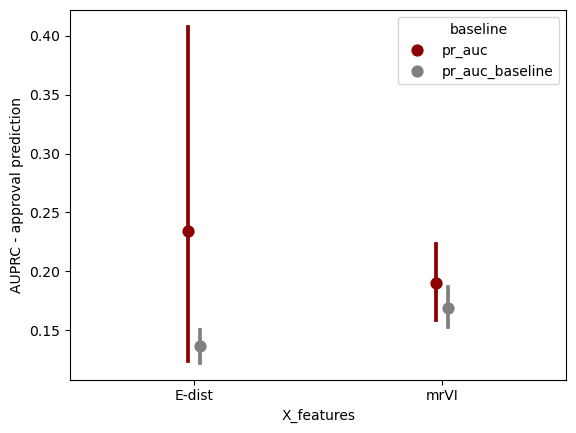

In [23]:
pl_df = all_results_df.drop('accuracy', axis=1).melt(id_vars=['split_seed', 'n_samples', 'X_features'], var_name='baseline', value_name='AUPRC')
sns.pointplot(
    data=pl_df,
    x='X_features', y='AUPRC',
    hue='baseline',
    linestyles='none',
    dodge=True,
    errorbar=('ci', 95),
    palette={'pr_auc_baseline': 'grey', 'pr_auc': 'darkred'}
    );
plt.ylabel('AUPRC - approval prediction')

In [27]:
common_drug_organ = np.intersect1d(edist_df['drug_organ'].unique(), depmap_dependency['drug_organ'].unique())

In [30]:
common_drug_organ

array(['(R)-Verapamil (hydrochloride)_Bladder/Urinary Tract',
       '(R)-Verapamil (hydrochloride)_Bowel',
       '(R)-Verapamil (hydrochloride)_Breast', ...,
       'venetoclax_Peripheral Nervous System', 'venetoclax_Skin',
       'venetoclax_Uterus'], dtype=object)